# Notes

sampling methods
- simple random sampling
- stratified random sampling
- cluster sampling
- systematic sampling
- convenience sampling
- judgement sampling

Hypothesis testing
- null and alternative
- reject null -> type I error (alpha)
- accept null -> type II error (beta)
- random sample / matched sample
- test of independence

ANOVA
- comparing means
- bonferroni correction and other techniques for correcting error rates
- randomized block design
- 2-factor design

Linear regression
- 5 assumptions of linear regression
- significance: t test and F test
    - caution: no casual relationship / extrapolation
- residuals plots
- check for outlier and influential observation
    - remove to see impact
    - leverage and cook's distance
- check for multicollinearity

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
from collections.abc import Iterable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
import pmdarima as pm
import warnings
from statsmodels.tools.sm_exceptions import ModelWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

from linear_reg_diagnostics import Linear_Reg_Diagnostics # custom module

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [417]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import data

## Neighbourhood population

In [5]:
neighbourhoods = gpd.read_file('./clean_data/neighbourhoods.geojson', driver='GeoJSON')
neighbourhood_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods.columns if re.search('\d+', x) is not None])))
neighbourhoods_select = neighbourhoods[['hood_id'] + 
                                       ['Population_' + x for x in neighbourhood_years]]
neighbourhoods_select = neighbourhoods_select.copy()
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhoods_select['Population_2021'] = (neighbourhoods_select['Population_2020'] * neighbourhoods_select['Population_2020'] / neighbourhoods_select['Population_2019']).values
neighbourhoods_population = pd.wide_to_long(neighbourhoods_select, stubnames='Population', i='hood_id', j='Year', sep='_').reset_index()
neighbourhoods_population

hood_id  Year    Population
0         97  2014  12597.000000
1         27  2014  28719.000000
2         38  2014  16086.000000
3         31  2014  15196.000000
4         16  2014  25636.000000
...      ...   ...           ...
1115      46  2021  16985.994859
1116      94  2021  16351.031153
1117      56  2021  18969.209689
1118     108  2021  15620.936759
1119      17  2021  39658.358942

[1120 rows x 3 columns]

## Distance from University of Toronto

In [6]:
distance_df = neighbourhoods[['hood_id', 'distance_km']]
distance_df

hood_id  distance_km
0        97     2.791462
1        27    13.676191
2        38    10.427749
3        31     7.592207
4        16     9.017845
..      ...          ...
135      46    14.643244
136      94     2.864021
137      56     5.149543
138     108     6.111904
139      17     9.894878

[140 rows x 2 columns]

## Crime rate

In [7]:
mci_df = pd.read_csv('./clean_data/mci_select.csv')[['occurrencedate', 'MCI', 'hood_id', 'Neighbourhood']]
mci_df = mci_df.copy()
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate']).dt.tz_localize(None)
mci_df.set_index('occurrencedate', inplace=True)
mci_df['hood_id'] = mci_df['hood_id'].astype(str)
mci_df = mci_df.loc[(mci_df['hood_id'] != 'NSA') & (mci_df['MCI'] != 'Shootings') & (mci_df['MCI'] != 'Homicide')]
mci_df = mci_df.groupby('hood_id').resample('Q').size().T.reset_index().melt(id_vars='occurrencedate', var_name='hood_id', value_name='MCI_Count')
mci_df['Year'] = mci_df['occurrencedate'].dt.year
mci_df = mci_df.merge(neighbourhoods_population, on=['hood_id', 'Year'])
mci_df['MCI_Rate'] = mci_df['MCI_Count'].div(mci_df['Population']).mul(10**5)
mci_df

C:\Users\willi\AppData\Local\Temp\ipykernel_29880\1039957768.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



occurrencedate hood_id  MCI_Count  Year    Population    MCI_Rate
0        2014-03-31       1        191  2014  34745.000000  549.719384
1        2014-06-30       1        262  2014  34745.000000  754.065333
2        2014-09-30       1        206  2014  34745.000000  592.891063
3        2014-12-31       1        228  2014  34745.000000  656.209527
4        2015-03-31       1        159  2015  34557.000000  460.109384
...             ...     ...        ...   ...           ...         ...
4475     2020-12-31      99         24  2020  17972.000000  133.541064
4476     2021-03-31      99         22  2021  18133.437233  121.322834
4477     2021-06-30      99         40  2021  18133.437233  220.586971
4478     2021-09-30      99         31  2021  18133.437233  170.954903
4479     2021-12-31      99         34  2021  18133.437233  187.498926

[4480 rows x 6 columns]

## Traffic collisions

In [8]:
collision_df = pd.read_csv('./clean_data/collision_point.csv')[['occurrencedate', 'hood_id', 'Neighbourhood']]
collision_df = collision_df.copy()
collision_df['occurrencedate'] = pd.to_datetime(collision_df['occurrencedate']).dt.tz_localize(None)
collision_df.set_index('occurrencedate', inplace=True)
collision_df['hood_id'] = collision_df['hood_id'].astype(str)
collision_df = collision_df.loc[(collision_df['hood_id'] != 'NSA')]
collision_df = collision_df.groupby('hood_id').resample('Q').size().T.reset_index().melt(id_vars='occurrencedate', var_name='hood_id', value_name='Collision_Count')
collision_df['Year'] = collision_df['occurrencedate'].dt.year
collision_df = collision_df.merge(neighbourhoods_population, on=['hood_id', 'Year'])
collision_df['Collision_Rate'] = collision_df['Collision_Count'].div(collision_df['Population']).mul(10**5)
collision_df

occurrencedate hood_id  Collision_Count  Year    Population  \
0        2014-03-31       1              352  2014  34745.000000   
1        2014-06-30       1              300  2014  34745.000000   
2        2014-09-30       1              317  2014  34745.000000   
3        2014-12-31       1              312  2014  34745.000000   
4        2015-03-31       1              334  2015  34557.000000   
...             ...     ...              ...   ...           ...   
4195     2020-06-30      99               37  2020  17972.000000   
4196     2020-09-30      99               80  2020  17972.000000   
4197     2020-12-31      99               74  2020  17972.000000   
4198     2021-03-31      99               54  2021  18133.437233   
4199     2021-06-30      99               45  2021  18133.437233   

      Collision_Rate  
0        1013.095409  
1         863.433588  
2         912.361491  
3         897.970931  
4         966.519084  
...              ...  
4195      205.875807  
4196      445.136880  
4197      411.751614  
4198      297.792411  
4199      248.160343  

[4200 rows x 6 columns]

## Lease rate

In [9]:
neighborhoods_rental = gpd.read_file('./clean_data/neighbourhoods_rental.geojson')
neighborhoods_rental = neighborhoods_rental[neighborhoods_rental['Year'] >= 2014]
neighborhoods_rental = neighborhoods_rental[['hood_id', 'Year', 'Quarter', 'All_Apartments_Leased_vs_Listed', 'All_Apartments_Avg_Lease_Rate_Per_Room']]
neighborhoods_rental['occurrencedate'] = pd.date_range(start = str(neighborhoods_rental.Year.min()) + '-01-01', 
                                                       end = str(neighborhoods_rental.Year.max()) + '-12-31', 
                                                       freq = 'Q').tolist() * len(neighborhoods_rental.hood_id.unique())
neighborhoods_rental

hood_id  Year  Quarter  All_Apartments_Leased_vs_Listed  \
8         97  2014        1                         0.414530   
9         97  2014        2                         0.437768   
10        97  2014        3                         0.474708   
11        97  2014        4                         0.338028   
12        97  2015        1                         0.320210   
...      ...   ...      ...                              ...   
5595     104  2020        4                         0.389210   
5596     104  2021        1                         0.428866   
5597     104  2021        2                         0.571429   
5598     104  2021        3                         0.743938   
5599     104  2021        4                         0.647555   

      All_Apartments_Avg_Lease_Rate_Per_Room occurrencedate  
8                                2023.736111     2014-03-31  
9                                2112.973510     2014-06-30  
10                               2299.291667     2014-09-30  
11                               2292.481481     2014-12-31  
12                               2298.331461     2015-03-31  
...                                      ...            ...  
5595                             1589.607422     2020-12-31  
5596                             1544.625239     2021-03-31  
5597                             1547.933680     2021-06-30  
5598                             1628.854754     2021-09-30  
5599                             1685.476768     2021-12-31  

[4480 rows x 6 columns]

# Create regression_df

In [10]:
neighborhoods_rental = neighborhoods_rental[['hood_id', 'All_Apartments_Leased_vs_Listed', 'All_Apartments_Avg_Lease_Rate_Per_Room', 'occurrencedate']]
mci_df = mci_df[['hood_id', 'occurrencedate', 'MCI_Rate']]
collision_df = collision_df[['hood_id', 'occurrencedate', 'Collision_Rate']]
regression_table = neighborhoods_rental.merge(mci_df, on=['hood_id', 'occurrencedate'], how='outer').merge(collision_df, on=['hood_id', 'occurrencedate'], how='outer').merge(distance_df, on=['hood_id'], how='outer')
regression_table.ffill(inplace=True)

In [11]:
Y = 'All_Apartments_Avg_Lease_Rate_Per_Room'
Xs = ['All_Apartments_Leased_vs_Listed', 'MCI_Rate', 'Collision_Rate', 'distance_km']
regression_table[['hood_id', 'occurrencedate'] + [Y] + Xs]

hood_id occurrencedate  All_Apartments_Avg_Lease_Rate_Per_Room  \
0         97     2014-03-31                             2023.736111   
1         97     2014-06-30                             2112.973510   
2         97     2014-09-30                             2299.291667   
3         97     2014-12-31                             2292.481481   
4         97     2015-03-31                             2298.331461   
...      ...            ...                                     ...   
4475     104     2020-12-31                             1589.607422   
4476     104     2021-03-31                             1544.625239   
4477     104     2021-06-30                             1547.933680   
4478     104     2021-09-30                             1628.854754   
4479     104     2021-12-31                             1685.476768   

      All_Apartments_Leased_vs_Listed    MCI_Rate  Collision_Rate  distance_km  
0                            0.414530   79.383980      539.811066     2.791462  
1                            0.437768  174.644757      468.365484     2.791462  
2                            0.474708  150.829563      404.858300     2.791462  
3                            0.338028   95.260776      476.303882     2.791462  
4                            0.320210   94.147183      478.581516     2.791462  
...                               ...         ...             ...          ...  
4475                         0.389210  253.220302      104.590994     4.632290  
4476                         0.428866  245.989395      134.897410     4.632290  
4477                         0.571429  235.409206      126.962268     4.632290  
4478                         0.743938  193.088450      126.962268     4.632290  
4479                         0.647555  251.279489      126.962268     4.632290  

[4480 rows x 7 columns]

In [12]:
regression_df = regression_table[[Y] + Xs].copy()
regression_df['Time'] = regression_table['occurrencedate'].dt.year + regression_table['occurrencedate'].dt.month / 12
regression_df['Quarter'] = regression_table['occurrencedate'].dt.quarter
regression_df['hood_id'] = regression_table['hood_id']
# regression_df = pd.concat([regression_df, 
#                            pd.get_dummies(pd.Series(['Q' + str(x) for x in regression_table['occurrencedate'].dt.quarter]), drop_first = True),
#                            pd.get_dummies(pd.Series(['N' + str(x) for x in regression_table['hood_id']]), drop_first = True)],
#                           axis=1)
regression_df.rename(columns={'All_Apartments_Avg_Lease_Rate_Per_Room': 'Rent',
                              'All_Apartments_Leased_vs_Listed': 'Lease_Demand',
                              'MCI_Rate': 'Crime',
                              'Collision_Rate': 'Traffic_Collisions',
                              'distance_km': 'Distance'}, inplace=True)
regression_df

Rent  Lease_Demand       Crime  Traffic_Collisions  Distance  \
0     2023.736111      0.414530   79.383980          539.811066  2.791462   
1     2112.973510      0.437768  174.644757          468.365484  2.791462   
2     2299.291667      0.474708  150.829563          404.858300  2.791462   
3     2292.481481      0.338028   95.260776          476.303882  2.791462   
4     2298.331461      0.320210   94.147183          478.581516  2.791462   
...           ...           ...         ...                 ...       ...   
4475  1589.607422      0.389210  253.220302          104.590994  4.632290   
4476  1544.625239      0.428866  245.989395          134.897410  4.632290   
4477  1547.933680      0.571429  235.409206          126.962268  4.632290   
4478  1628.854754      0.743938  193.088450          126.962268  4.632290   
4479  1685.476768      0.647555  251.279489          126.962268  4.632290   

         Time  Quarter hood_id  
0     2014.25        1      97  
1     2014.50        2      97  
2     2014.75        3      97  
3     2015.00        4      97  
4     2015.25        1      97  
...       ...      ...     ...  
4475  2021.00        4     104  
4476  2021.25        1     104  
4477  2021.50        2     104  
4478  2021.75        3     104  
4479  2022.00        4     104  

[4480 rows x 8 columns]

In [13]:
# time = ['Time']
# quarters = [re.search('Q\d+', x).group(0) for x in regression_df.columns if re.search('Q\d+', x) is not None]
# neighbourhood_id = [re.search('N\d+', x).group(0) for x in regression_df.columns if re.search('N\d+', x) is not None]

Y = 'Rent'
Xs_numeric = ['Lease_Demand', 'Crime', 'Traffic_Collisions', 'Distance']
# Xs = Xs_numeric + time + quarters + neighbourhood_id
Xs = Xs_numeric + ['Time', 'C(Quarter)', 'C(hood_id)']

## Standardize quantitative independent variables
- Ease of interpretation by avoiding extremely small or large coefficients
- Each estimated coefficient = impact on Y given + 1 sd movement in X given other independent variables are kept constant
- Distribution of independent variables will remain the same

In [14]:
regression_df[Xs_numeric] = stats.zscore(regression_df[Xs_numeric])

In [15]:
regression_df

Rent  Lease_Demand     Crime  Traffic_Collisions  Distance  \
0     2023.736111     -0.989455 -1.294872            0.258254 -1.284341   
1     2112.973510     -0.838697 -0.705158            0.011755 -1.284341   
2     2299.291667     -0.599050 -0.852586           -0.207356 -1.284341   
3     2292.481481     -1.485758 -1.196586            0.039143 -1.284341   
4     2298.331461     -1.601353 -1.203480            0.047002 -1.284341   
...           ...           ...       ...                 ...       ...   
4475  1589.607422     -1.153717 -0.218735           -1.243329 -0.946784   
4476  1544.625239     -0.896450 -0.263498           -1.138767 -0.946784   
4477  1547.933680      0.028420 -0.328994           -1.166144 -0.946784   
4478  1628.854754      1.147569 -0.590982           -1.166144 -0.946784   
4479  1685.476768      0.522287 -0.230749           -1.166144 -0.946784   

         Time  Quarter hood_id  
0     2014.25        1      97  
1     2014.50        2      97  
2     2014.75        3      97  
3     2015.00        4      97  
4     2015.25        1      97  
...       ...      ...     ...  
4475  2021.00        4     104  
4476  2021.25        1     104  
4477  2021.50        2     104  
4478  2021.75        3     104  
4479  2022.00        4     104  

[4480 rows x 8 columns]

# Correlation plot
- The first row of correlation matrix shows the correlation between our dependent variable (Rent) and other independent variables. 
- It makes sense that distance from the University of Toronto has a negative correlation with rent since you need to spend more time on commute if you live further away from the city centre.
- given the strong correlation between crime and traffic collision, we might need to check if there is  multicollinearity
- The first row of pairplot shows the linear regression results between Y and Xs

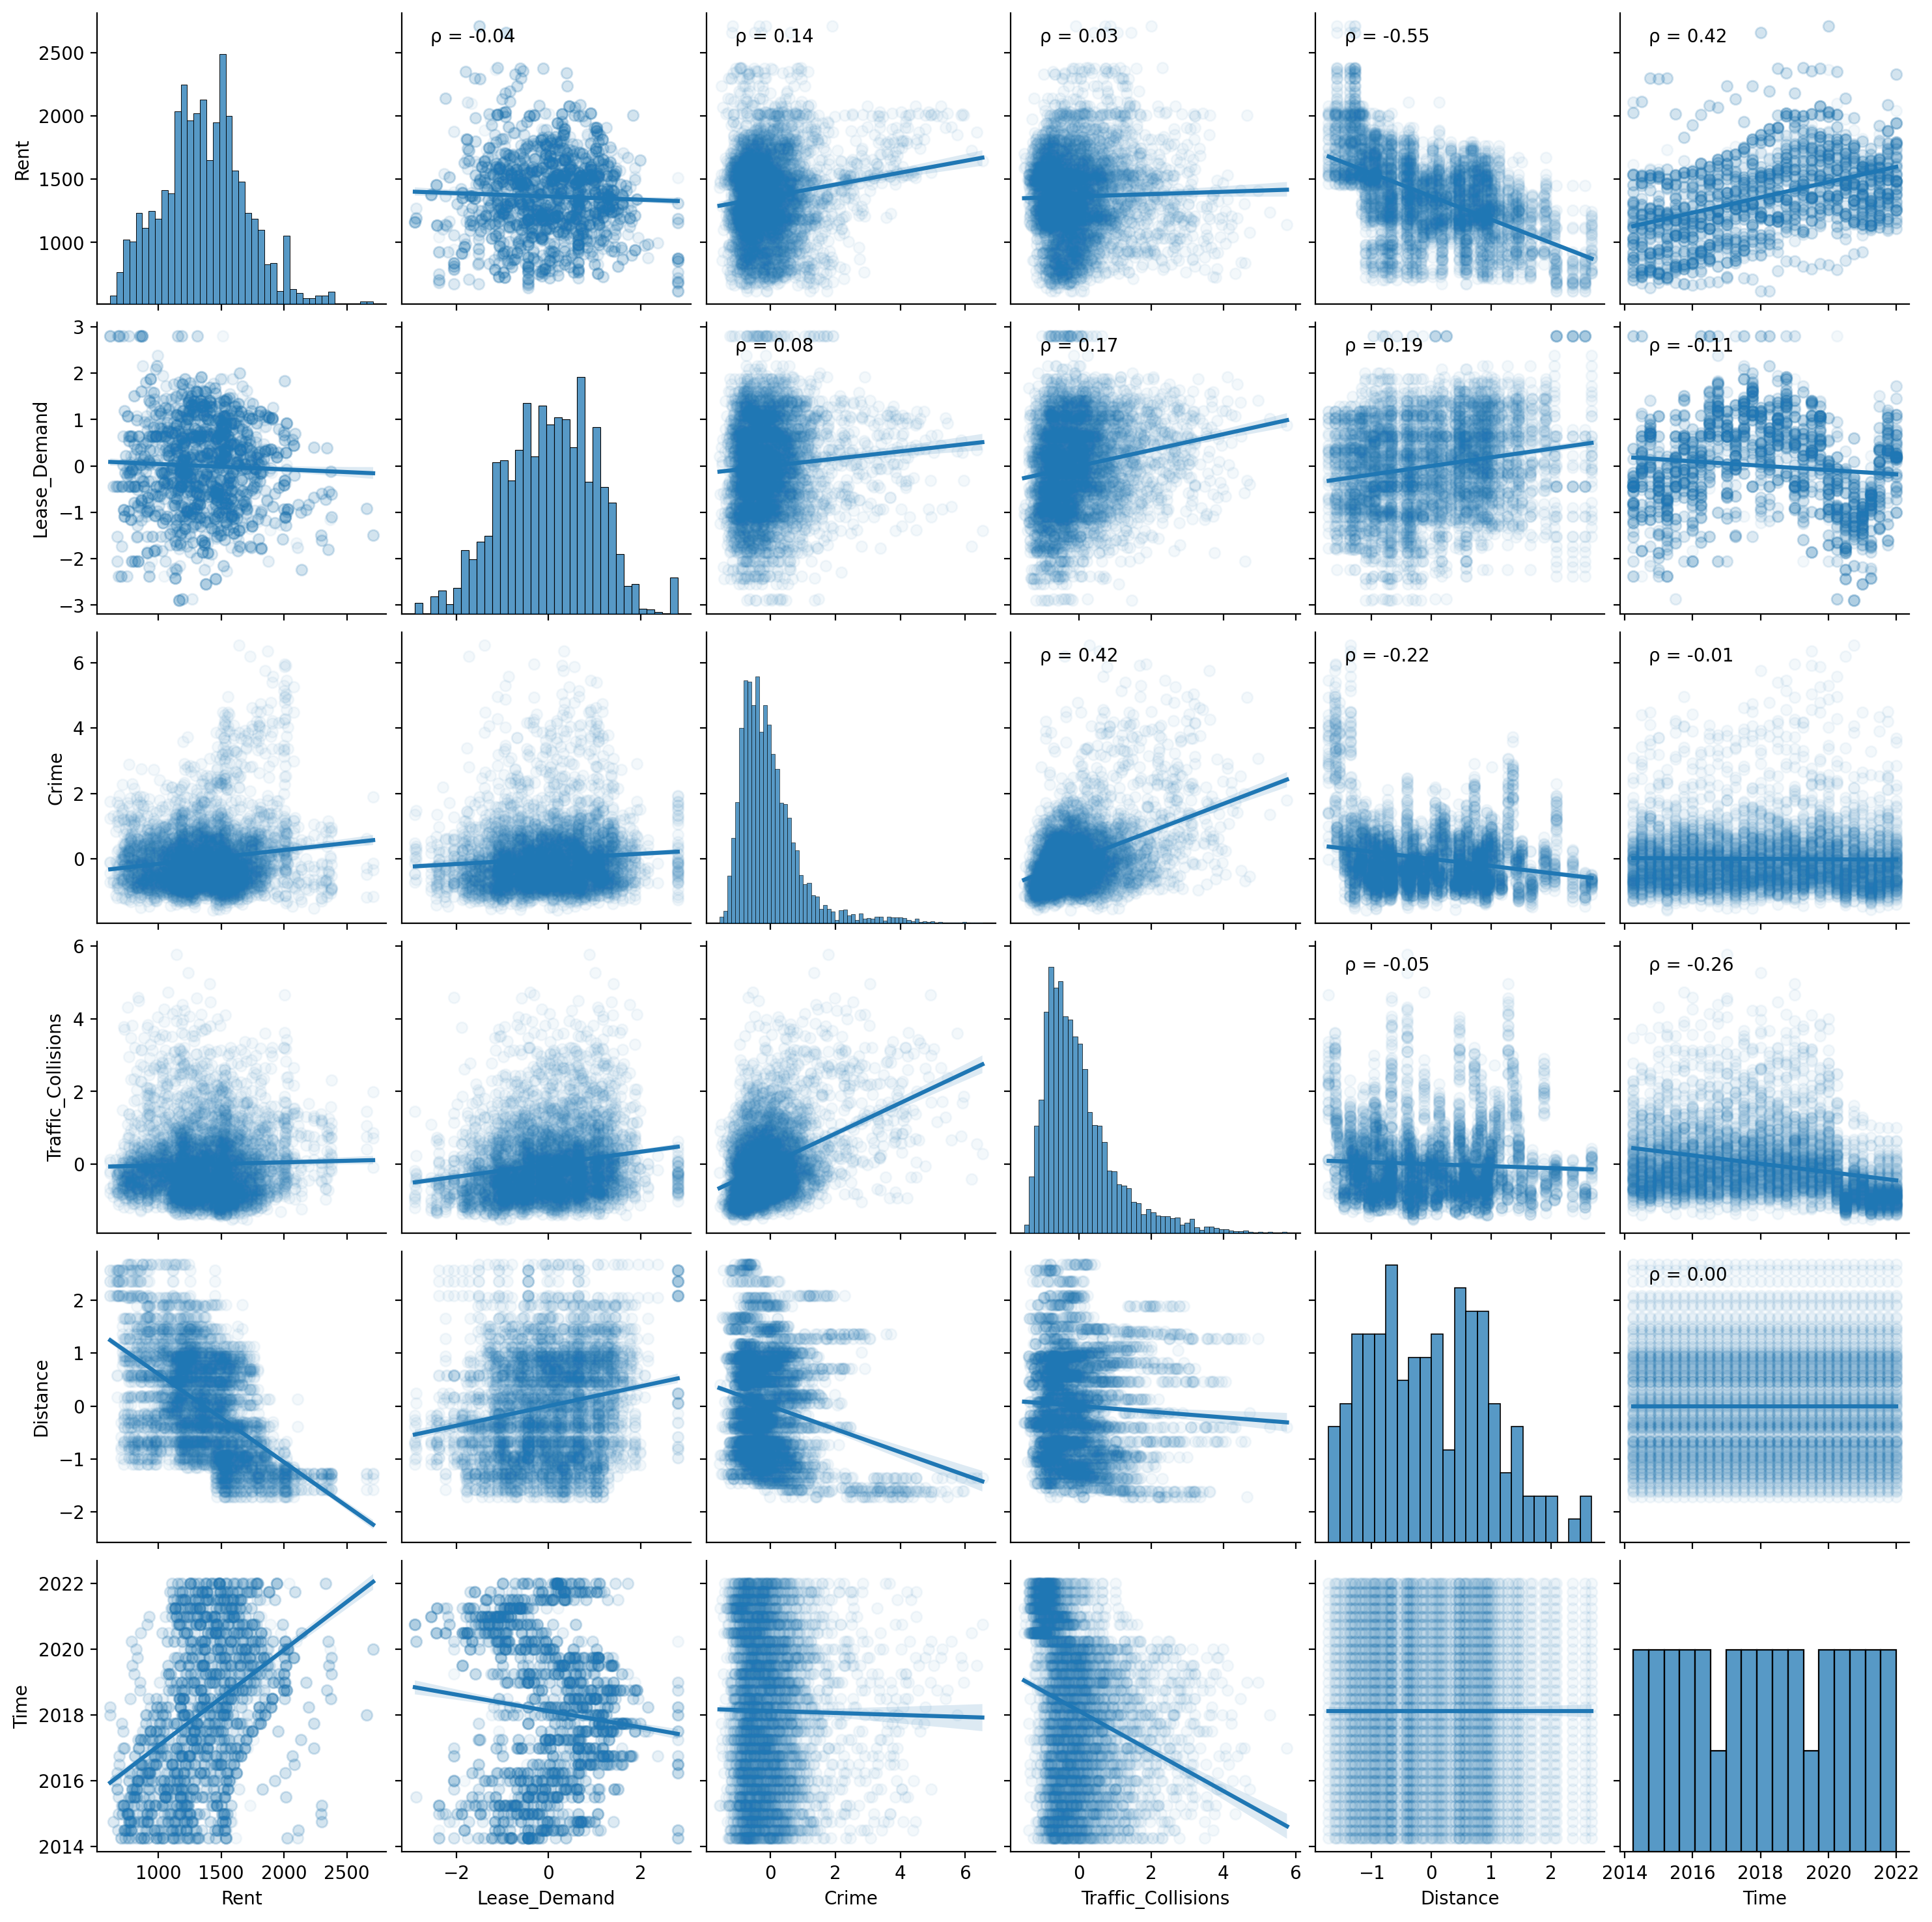

In [16]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r = np.corrcoef(x, y)[0,1]
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.pairplot(regression_df[[Y] + Xs_numeric + ['Time']], 
             kind = 'reg', 
             diag_kind='hist', 
             plot_kws={'scatter_kws': {'alpha':0.05}})
g.map_upper(corrfunc)
g

# Panel data regression result
- Our data is a panel data with time and hood_ID
- Instead of doing a pooled OLS, let's take into account of the time and neighbourhood_ID to build a LSDV model
  - fixed effects instead of random effects
    - fixed effects eliminate omitted variable bias -> improve interpretability of coefficients
    - fixed effects do not assume any particular distribution
- Trade-off between flexibility to measure heterogenity, and pooling data to estimate shared parameters more precisely
- https://faculty.washington.edu/cadolph/?page=24 

## Best-subsets regression
- Variable selection procedure for a specified number of independent variables based on adjusted R square
- Given there is no significant benefit from including variables other than distance, let's use that as our model

In [17]:
def flatten(l):
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [18]:
# https://www.statsmodels.org/devel/example_formulas.html
best_models = []
for i in range(len(Xs)):
    n = i + 1
    best_rsq = 0
    best_combo = []
    for combo in itertools.combinations(Xs, n):
        rsq_adj = smf.ols(formula = Y + ' ~ ' + ' + '.join(combo), data = regression_df).fit().rsquared_adj
        if rsq_adj > best_rsq:
            best_combo = combo
            best_rsq = rsq_adj
    best_models.append(best_combo)
    print(f"Highest adjusted R squared achieved with {n} variable(s) = {best_rsq:0.3f} = {Y} ~ {' + '.join(best_combo)}")

Highest adjusted R squared achieved with 1 variable(s) = 0.669 = Rent ~ C(hood_id)
Highest adjusted R squared achieved with 2 variable(s) = 0.852 = Rent ~ Time + C(hood_id)
Highest adjusted R squared achieved with 3 variable(s) = 0.872 = Rent ~ Traffic_Collisions + Time + C(hood_id)
Highest adjusted R squared achieved with 4 variable(s) = 0.873 = Rent ~ Lease_Demand + Traffic_Collisions + Time + C(hood_id)
Highest adjusted R squared achieved with 5 variable(s) = 0.873 = Rent ~ Lease_Demand + Crime + Traffic_Collisions + Time + C(hood_id)
Highest adjusted R squared achieved with 6 variable(s) = 0.873 = Rent ~ Lease_Demand + Crime + Traffic_Collisions + Time + C(Quarter) + C(hood_id)
Highest adjusted R squared achieved with 7 variable(s) = 0.873 = Rent ~ Lease_Demand + Crime + Traffic_Collisions + Distance + Time + C(Quarter) + C(hood_id)


In [19]:
# Let's pick the best model with 3 variables as R squared does not seem to improve after adding extra variables
Xs_best_subset = ['Traffic_Collisions', 'Time', 'C(hood_id)']
best_subset = smf.ols(formula = Y + ' ~ ' + ' + '.join(Xs_best_subset), data = regression_df).fit()

In [20]:
# Significant F value
print(f"F value: {best_subset.fvalue:0.3f}, p-value: {best_subset.f_pvalue:0.3f}")

F value: 217.029, p-value: 0.000


### First take
- While F test is significant, we need to rule out the impact from outliers, influential observations and multicollinearity
- VIF of Traffic_Collisions at 4.08 suggest some degree of multicollinearity
  - Indeed the positive sign of traffic_collisions to rent is hardly justified
    - Does it mean people prefer apartments in neighbourhood with higher rate of traffic accidents?
    - Does it mean people prefer crowder areas such that there are more cars on the road leading to a higher rate of traffic accidents?
- No outliers and influential observations

In [21]:
# Check multicollinearity
cls = Linear_Reg_Diagnostics(best_subset)
cls.vif_table()

               Features  VIF Factor
139  Traffic_Collisions        4.08
16    C(hood_id)[T.114]        2.25
96     C(hood_id)[T.60]        2.22
7     C(hood_id)[T.106]        2.22
128     C(hood_id)[T.9]        2.21
..                  ...         ...
34    C(hood_id)[T.130]        1.99
59     C(hood_id)[T.27]        1.99
129    C(hood_id)[T.90]        1.99
116    C(hood_id)[T.79]        1.99
140                Time        1.28

[141 rows x 2 columns]


### Model refinement
- Let's pick the best model with 2 variables instead
  1) VIF of Traffic_Collisions at 4.08 suggest some degree of multicollinearity
  2) While adding Traffic_Collisions can improve the model, it does not seem to be significant based on the correlation plot
  3) Keeping time and hood_id as indepednet variables can also make prediction easier as both are fixed variables

In [402]:
# Let's pick the best model with 2 variables
# 1) while adding Traffic_Collisions can improve the model, it does not seem to be significant based on the correlation plot
# 2) keeping time and hood_id as indepednet variables can also make prediction easier as both are fixed variables
Xs_best_subset = ['Time', 'C(hood_id)']
best_subset = smf.ols(formula = Y + ' ~ ' + ' + '.join(Xs_best_subset), data = regression_df).fit()

In [403]:
best_subset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     184.7
Date:                Sun, 22 May 2022   Prob (F-statistic):               0.00
Time:                        09:30:02   Log-Likelihood:                -28019.
No. Observations:                4480   AIC:                         5.632e+04
Df Residuals:                    4339   BIC:                         5.722e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.209e+05   1670.892    -72.337      0.000   -1.24e+05   -1.18e+05
C(hood_id)[T.10]    237.9630     31.976      7.442      0.000     175.273     300.653
C(hood_id)[T.100]   422.2710     31.976     13.206      0.000     359.581     484.961
C(hood_id)[T.101]   422.2710     31.976     13.206      0.000     359.581     484.961
C(hood_id)[T.102]   344.4320     31.976     10.772      0.000     281.742     407.122
C(hood_id)[T.103]   344.4320     31.976     10.772      0.000     281.742     407.122
C(hood_id)[T.104]   518.1660     31.976     16.205      0.000     455.476     580.856
C(hood_id)[T.105]   344.4320     31.976     10.772      0.000     281.742     407.122
C(hood_id)[T.106]   422.2710     31.976     13.206      0.000     359.581     484.961
C(hood_id)[T.107]   422.2710     31.976     13.206      0.000     359.581     484.961
C(hood_id)[T.108]    98.3019     31.976      3.074      0.002      35.612     160.992
C(hood_id)[T.109]   -41.1264     31.976     -1.286      0.198    -103.816      21.563
C(hood_id)[T.11]    237.9630     31.976      7.442      0.000     175.273     300.653
C(hood_id)[T.110]   -41.1264     31.976     -1.286      0.198    -103.816      21.563
C(hood_id)[T.111]   -41.1264     31.976     -1.286      0.198    -103.816      21.563
C(hood_id)[T.112]    98.3019     31.976      3.074      0.002      35.612     160.992
C(hood_id)[T.113]    98.3019     31.976      3.074      0.002      35.612     160.992
C(hood_id)[T.114]   422.3628     31.976     13.209      0.000     359.673     485.053
C(hood_id)[T.115]    98.3019     31.976      3.074      0.002      35.612     160.992
C(hood_id)[T.116]   -50.8650     31.976     -1.591      0.112    -113.555      11.825
C(hood_id)[T.117]   -50.8650     31.976     -1.591      0.112    -113.555      11.825
C(hood_id)[T.118]   -50.8650     31.976     -1.591      0.112    -113.555      11.825
C(hood_id)[T.119]   -55.4274     31.976     -1.733      0.083    -118.117       7.262
C(hood_id)[T.12]    237.9630     31.976      7.442      0.000     175.273     300.653
C(hood_id)[T.120]   -55.4274     31.976     -1.733      0.083    -118.117       7.262
C(hood_id)[T.121]   147.8388     31.976      4.623      0.000      85.149     210.528
C(hood_id)[T.122]   147.8388     31.976      4.623      0.000      85.149     210.528
C(hood_id)[T.123]  -152.3607     31.976     -4.765      0.000    -215.050     -89.671
C(hood_id)[T.124]   -55.4274     31.976     -1.733      0.083    -118.117       7.262
C(hood_id)[T.125]   -55.4274     31.976     -1.733      0.083    -118.117       7.262
C(hood_id)[T.126]   -55.4274     31.976     -1.733      0.083    -118.117       7.262
C(hood_id)[T.127]   134.5869     31.976      4.209      0.000      71.897     197.277
C(hood_id)[T.128]   -13.3858     31.976     -0.419      0.676     -76.076

### Intuitive interpretation
- If we plot the Rent vs Time, you can see there is a general upward slope due to inflation
- If we group each neighbourhood, you can see while the slope is generally similar, they have 
  - different intercepts, and
  - similar slopes
- More expensive regions will tend to be more expensive

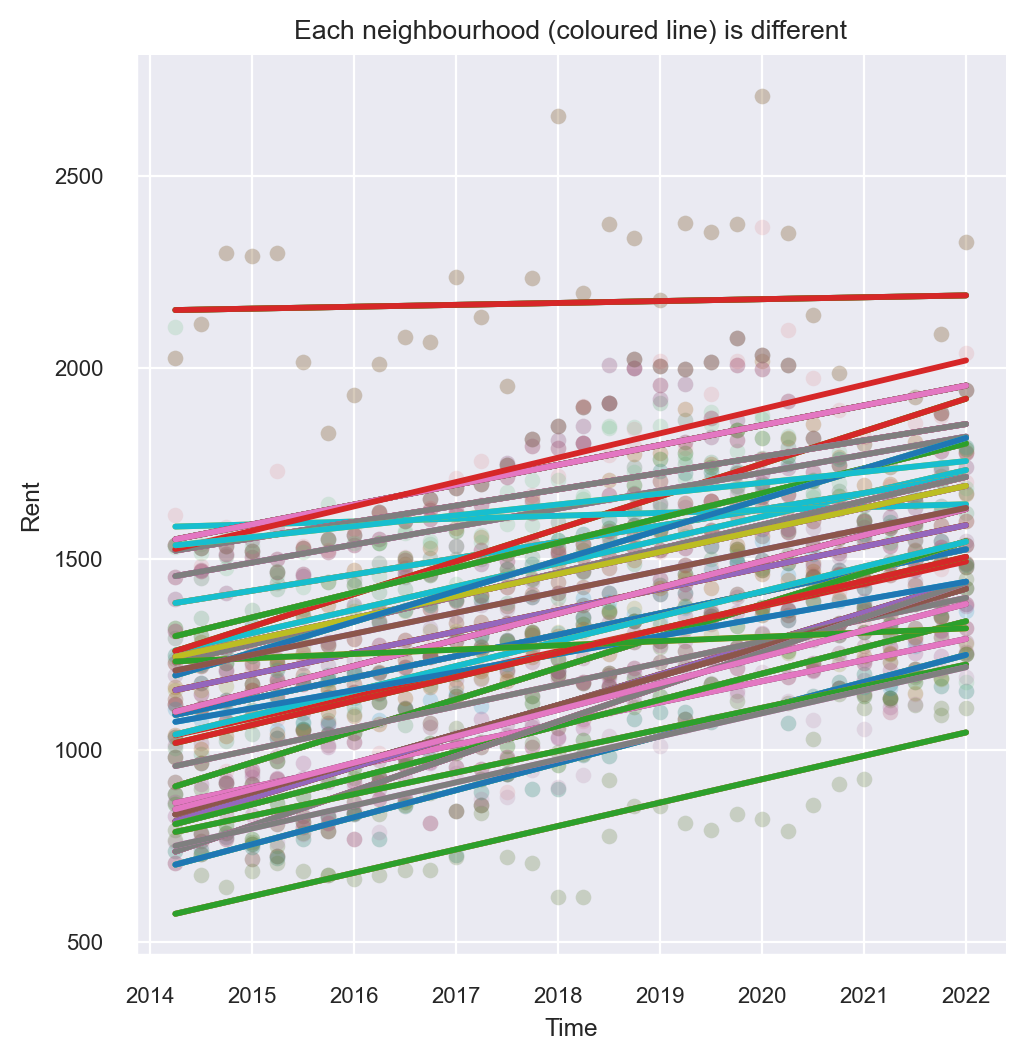

In [380]:
with plt.style.context('seaborn-paper'):
    sns.lmplot(x='Time', y='Rent', data=regression_df, hue='hood_id', palette='tab10', legend=False, ci=None, scatter_kws={'alpha':0.10}, size=5)
    plt.title('Each neighbourhood (coloured line) is different')

### Residual diagnostics

- Mulptiple signs show that the assumptions about regression residuals are violated 
  - Upper left: expected value of residuals is close to 0 but not constant across fitted values (y_hat)
  - Lower left: signs of heteroscedasticity and autocorrelation among residuals suggested by Ljung-Box test
  - Upper right: residuals do not follow normal distribution suggested by Jarque-Bera test and q-q plot
  - Lower right: there are no outliers or influential observations with Cook's distance > 1


Although the above departures from the assumptions might not be extreme enough to make the standard error of estimated parameters completely unreliable, 
  > let's not interpret the statistical tests first and verify the results with bootstrapping instead

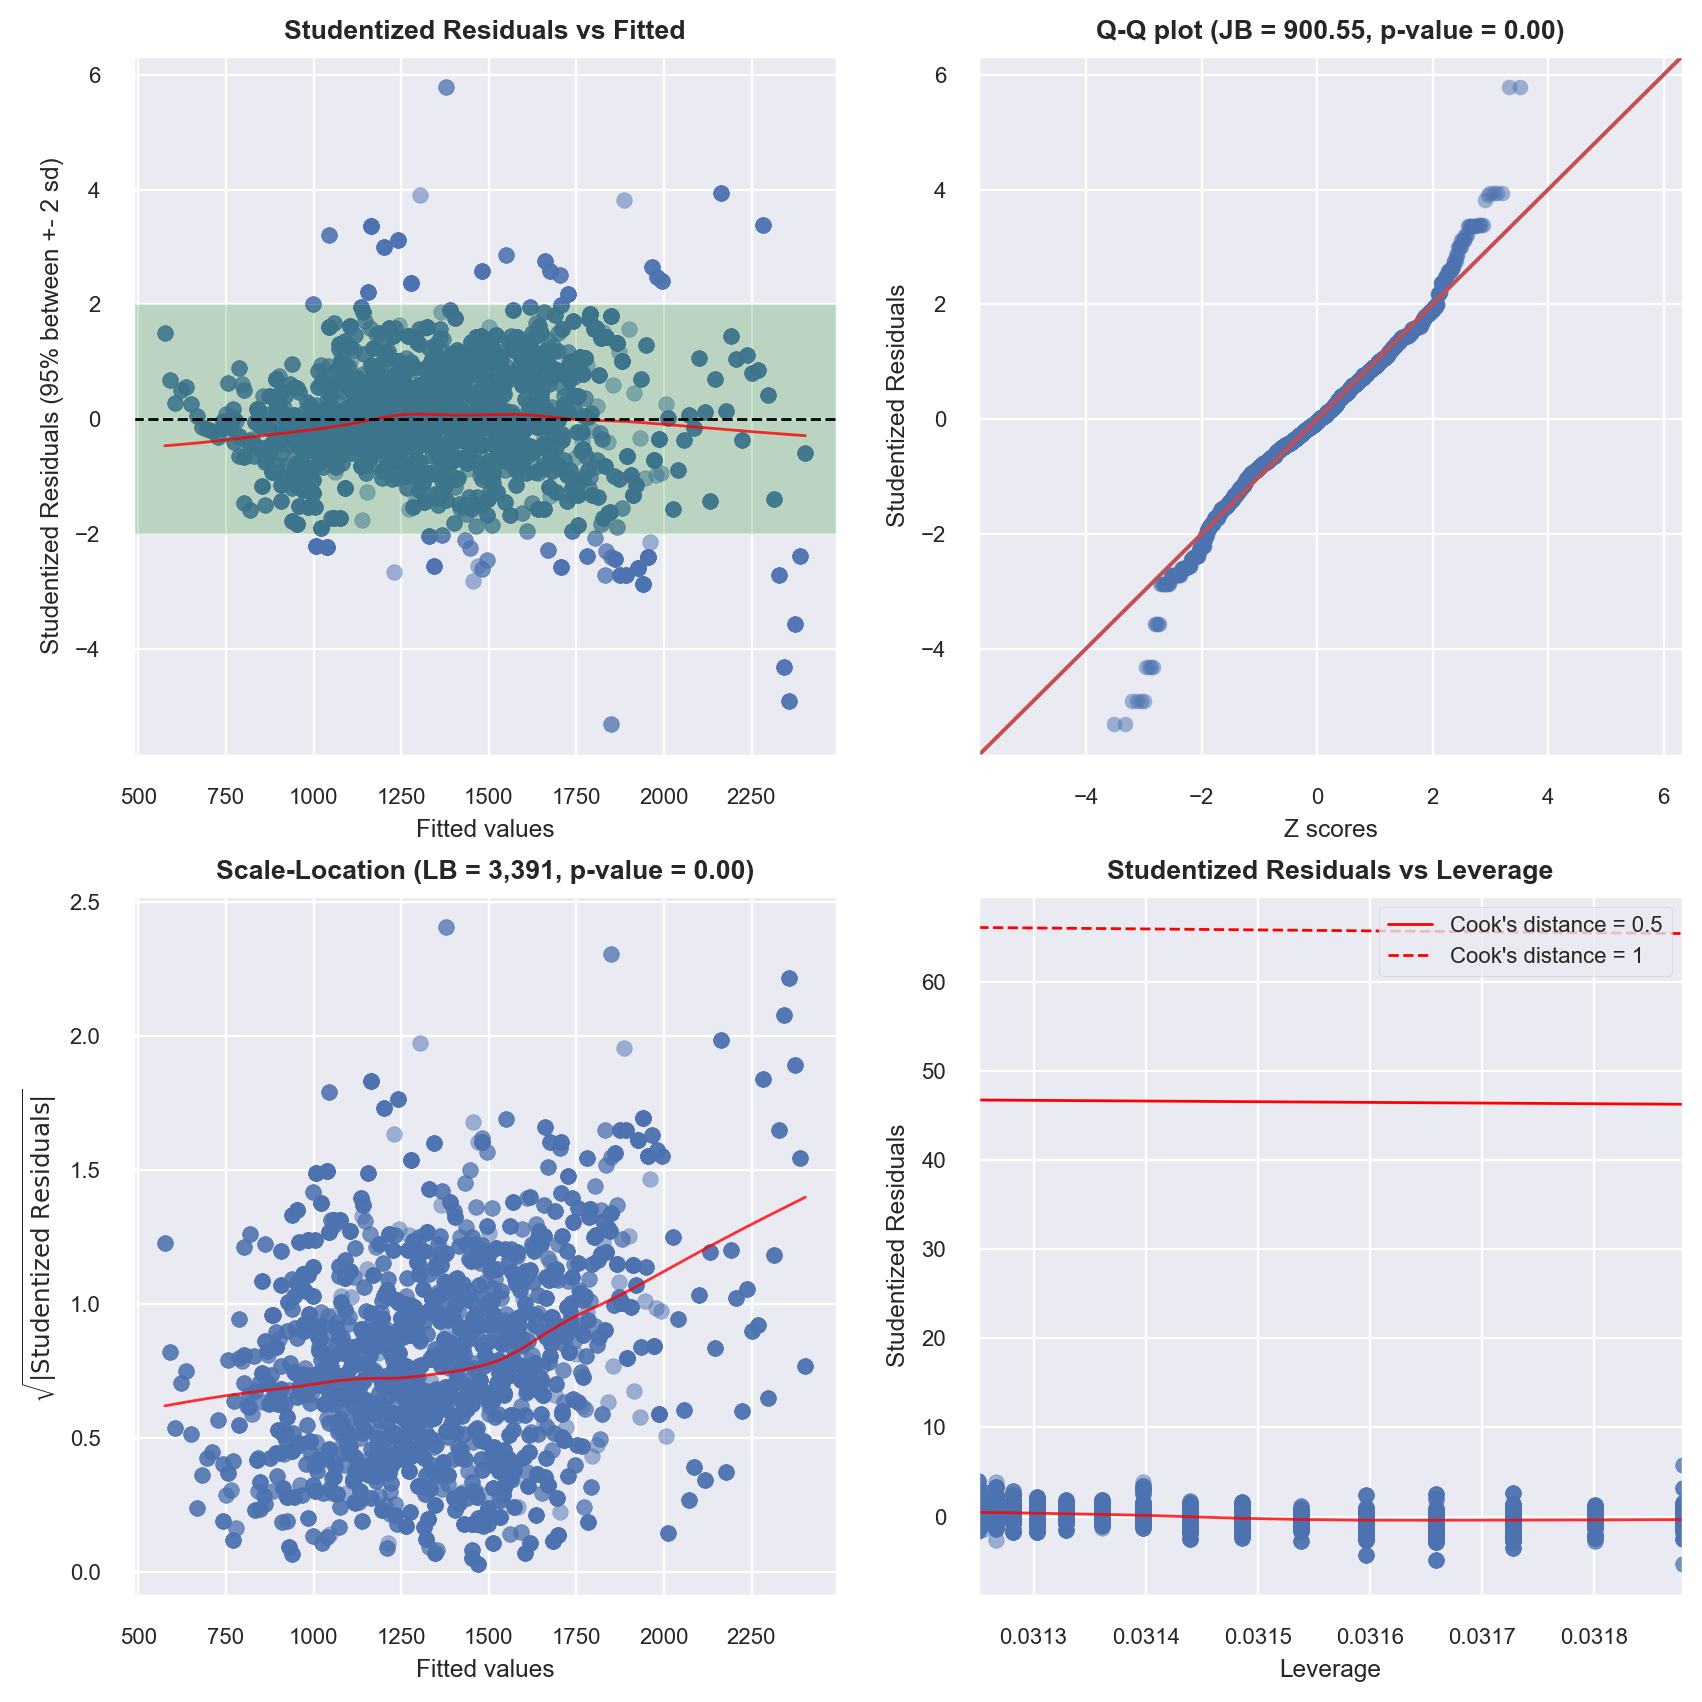

              Features  VIF Factor
26   C(hood_id)[T.123]        1.99
126   C(hood_id)[T.88]        1.99
22    C(hood_id)[T.12]        1.99
0     C(hood_id)[T.10]        1.99
79    C(hood_id)[T.45]        1.99
..                 ...         ...
29   C(hood_id)[T.126]        1.99
107   C(hood_id)[T.70]        1.99
108   C(hood_id)[T.71]        1.99
112   C(hood_id)[T.75]        1.99
139               Time        1.00

[140 rows x 2 columns]


In [391]:
# Let's check the residuals and multicollinearity again
cls = Linear_Reg_Diagnostics(best_subset)
fig, ax = cls()

### Bootstrapping F test
- While the F statistic suggests significance in our model, the assumptions of residuals are clearly violated 
- Thus we cannot trust that our F statistic will follow the asymptotic F distribution and trust the p-value for now
- Instead let's apply bootstrapping to see if our F statistic is really significant
- Bootstrapping Regression Models https://artowen.su.domains/courses/305-1314/FoxOnBootingRegInR.pdf
- https://stats.stackexchange.com/questions/59670/multiple-regression-and-multiple-comparisons
- https://stats.stackexchange.com/questions/167289/is-there-a-multiple-testing-problem-when-performing-t-tests-for-multiple-coeffci
- https://online.stat.psu.edu/stat462/node/135/

In [24]:
print(f"F value: {best_subset.fvalue}, p-value: {best_subset.f_pvalue:0.3f}")

F value: 184.7058434139458, p-value: 0.000


In [25]:
# compute F statistic to indicate the significance of extra variables by comparing the restricted vs full regression model
# def compute_F(formula_full, formula_restricted = None, data = regression_df, intercept_only = False):
#     full_model = smf.ols(formula = formula_full, data = data).fit()
    
#     if intercept_only:
#         # only consider the intercept
#         restricted_model = sm.OLS(regression_df[Y], np.ones(len(regression_df[Y]))).fit()
#     else:
#         restricted_model = smf.ols(formula = formula_restricted, data = data).fit()
#     F_value = (restricted_model.ssr - full_model.ssr) / (restricted_model.df_resid - full_model.df_resid) / (full_model.ssr / full_model.df_resid)
#     return F_value

# compute_F(formula_full= Y + ' ~ ' + ' + '.join(Xs_best_subset),
#           intercept_only=True)

In [26]:
# function to compute F value given the Y and Xs
def compute_F(df, null_true = False):
    X_df = pd.concat([pd.get_dummies(df['hood_id'], drop_first = True), df['Time']], axis=1)
    X_df.insert(0, 'Intercept', 1)
    X_df = X_df.values
    # speed up regression with matrix inverse method
    coef = np.linalg.inv(X_df.T @ X_df) @ X_df.T @ df[Y].values
    if null_true:
        # if null hypothesis of F test is true, all coefficients are zero except the intercept
        # Y would be a series of intercept + residuals
        resid = df[Y].values - X_df @ coef
        intercept = coef[0]
        Y_df = np.random.choice(intercept + resid, size = len(df[Y]), replace = True)
    else:
        Y_df = df[Y].values
    boot_coef = np.linalg.inv(X_df.T @ X_df) @ X_df.T @ Y_df
    # MSR = sum of squares due to regression / p
    msr = np.sum((X_df @ boot_coef - np.mean(Y_df))**2) / (len(boot_coef) - 1)
    # MSE = sum of squares due to error / (n - p - 1)
    mse = np.sum((Y_df - X_df @ boot_coef)**2) / (len(Y_df) - len(boot_coef))
    f_value = msr / mse
    return f_value

# test
compute_F(regression_df)

184.7058434105884

In [27]:
np.random.seed(123)
# calculating many bootstrap replicates
def draw_bs_reps(df, size=10**4):
    """Draw bootstrap F value of linear regression."""

    # Initialize array of replicates: bs_replicates
    bs_replicate_fvalue = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        inds = np.arange(df.shape[0])
        # generate a list of indices with replcaement with the same size as our original dataframe
        # to ensure the distribution of bootstrap replicates is the same as that of our estimated coefficients
        bs_inds = np.random.choice(inds, size = len(inds), replace = True)
        # pairwise bootstrapping on Y and Xs assuming random-x resampling
        # as fixed-x resampling assumes residuals are iid (which is not true as we see the mean and variance is not contsant from residual diagnostics)
        bootstrap_df = df.iloc[bs_inds]
        bs_replicate_fvalue[i] = compute_F(bootstrap_df, null_true=True)

    return bs_replicate_fvalue

In [28]:
# we may consider swithcing to fixed-x resampling if we want to cut the running time 
# as we will only need to run linear regression once instead of twice
bs_fvalue = draw_bs_reps(regression_df)

#### Bootstrapping diagnostics
Can we trust the bootstrapping results?
  - Our original sample size is big enough with 4,000+ unique rows to be representative of the underlying population
  - Number of bootstrapped samples at 10,000 is large enough 
  - Distribution of bootstrap F values look like F distribution

All the above signs can give us confidence to use the bootstrap replicates to gauge the statisitcal significance of our F statistic

> Given our bootstrapped F distribution, our observed F statistic is significant at 95% confidence

Text(1.2022012400046973, 500, '95th percentile cutoff = 1.2022')

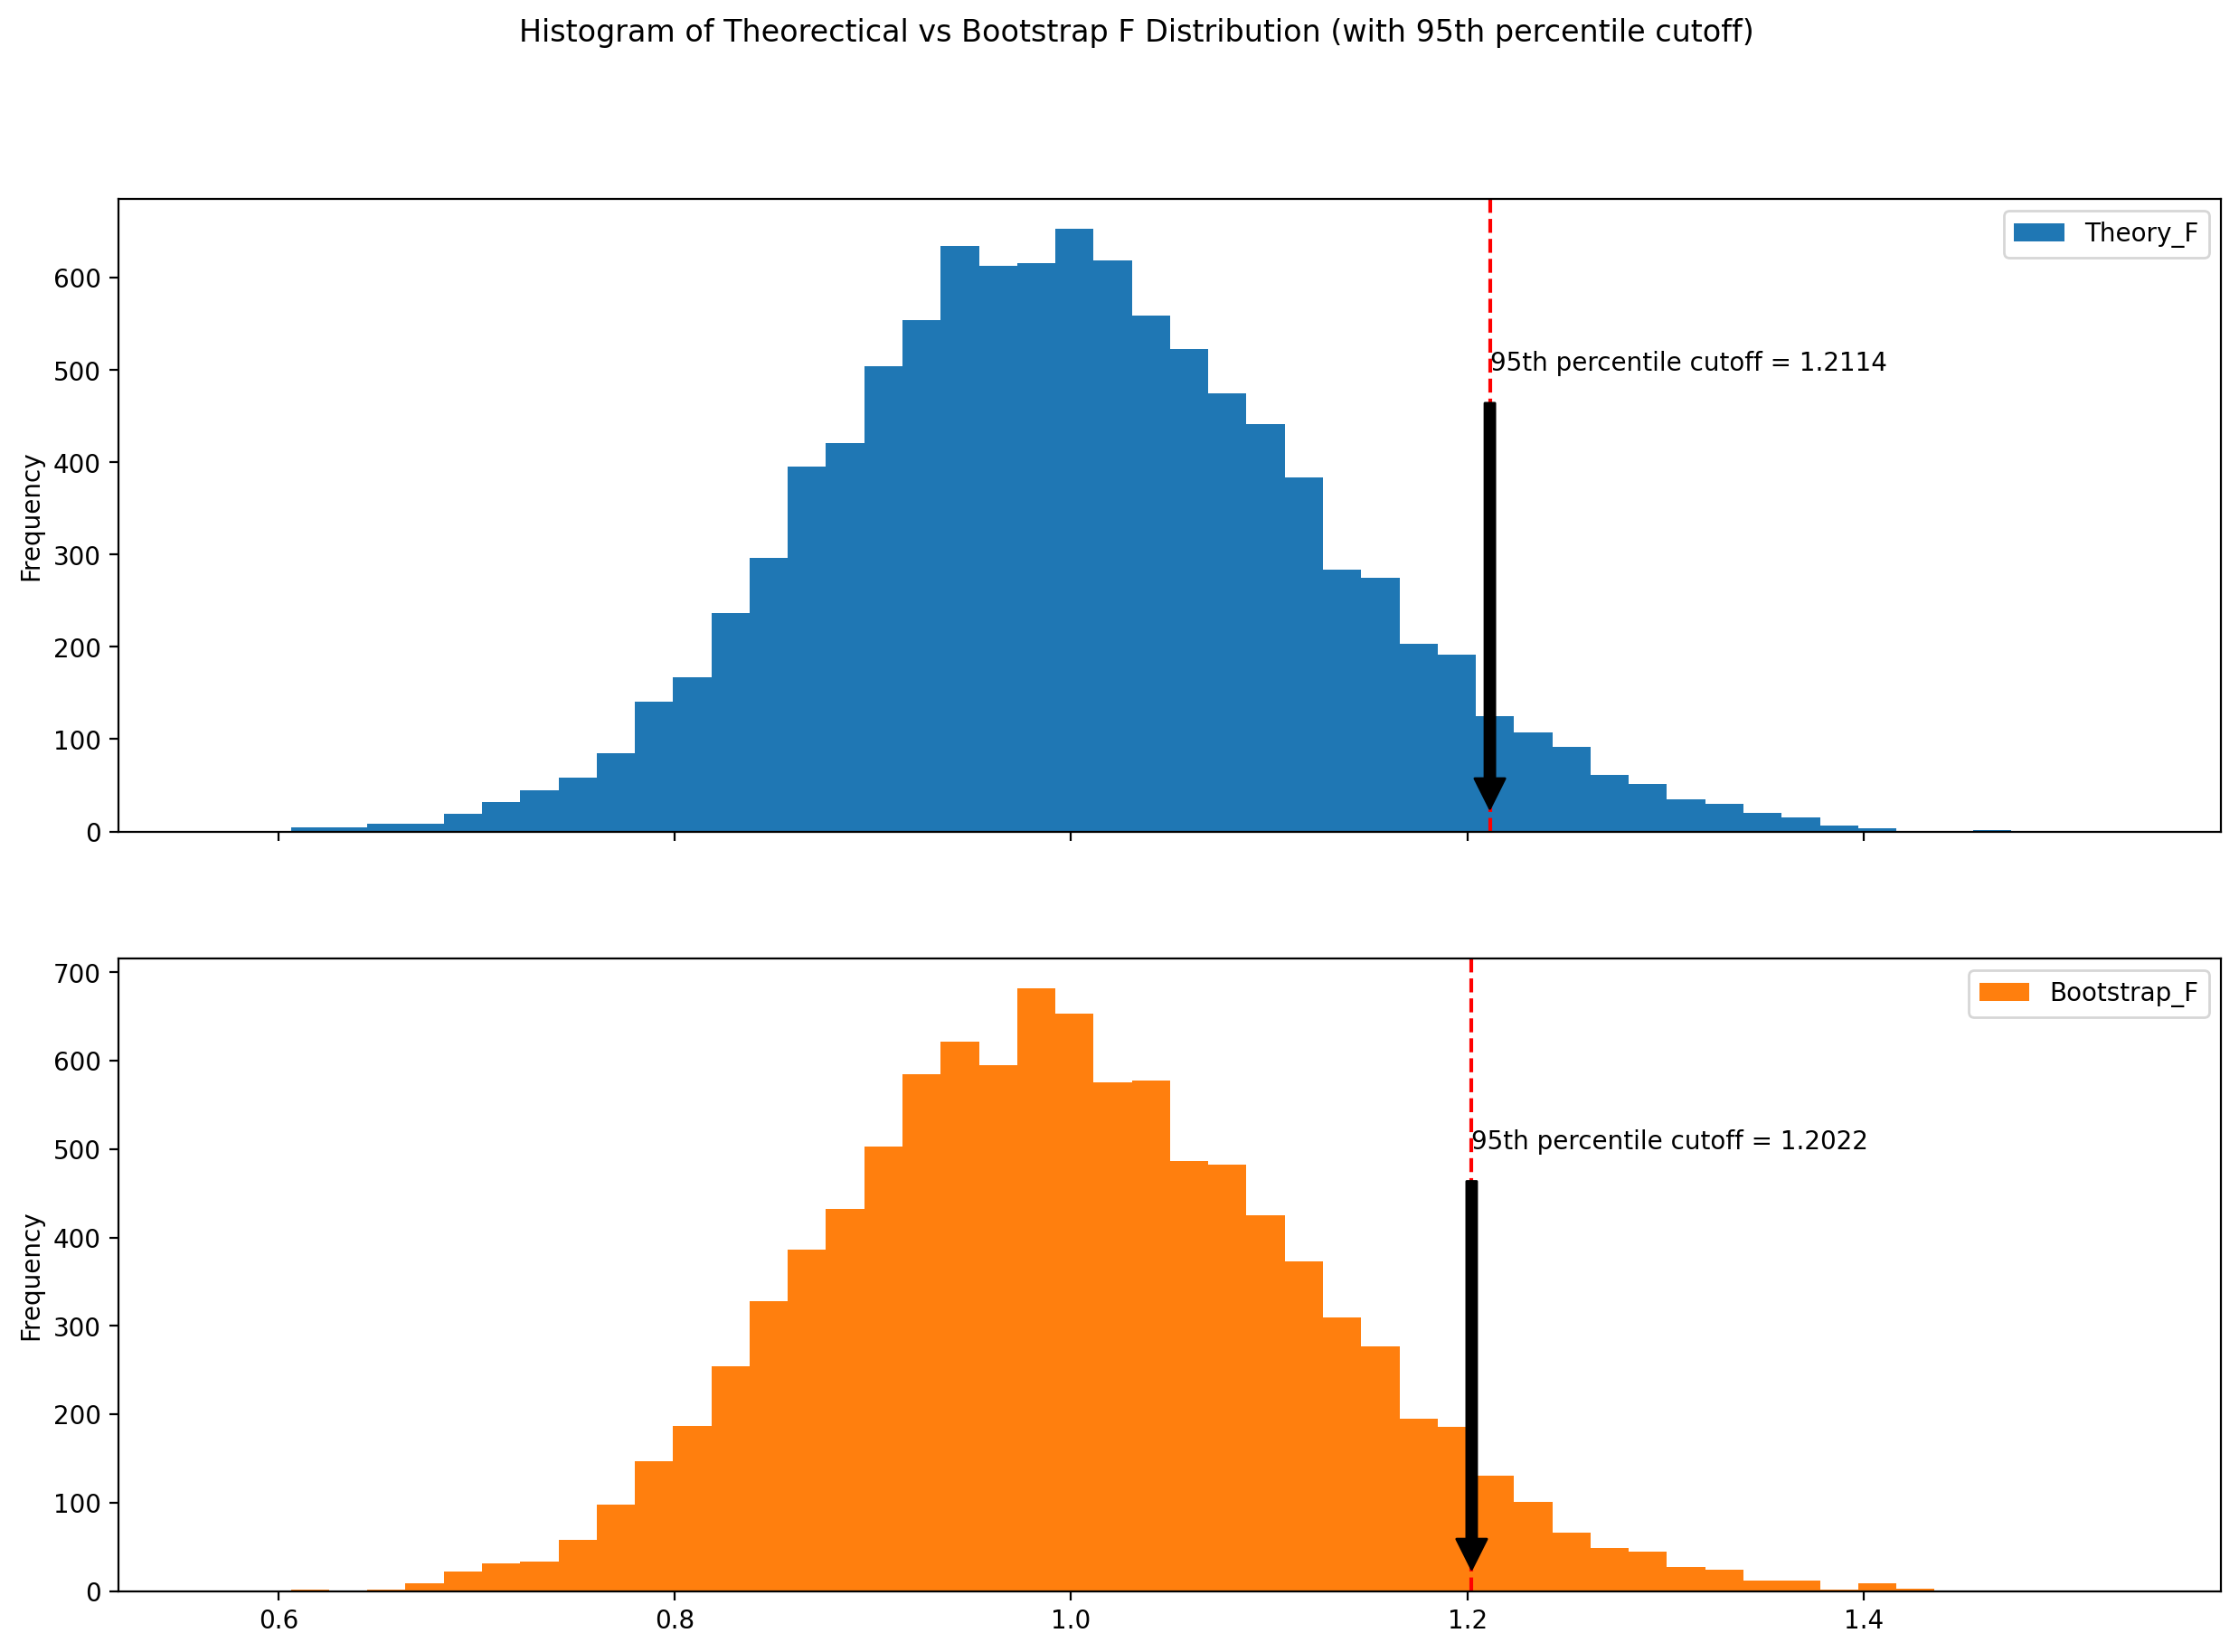

In [29]:
boot_df = pd.DataFrame({'Theory_F': np.random.f(best_subset.df_model, best_subset.df_resid, len(bs_fvalue)),
                        'Bootstrap_F': bs_fvalue})
ax = boot_df.plot(kind = 'hist', subplots = True, bins = 50, title = 'Histogram of Theorectical vs Bootstrap F Distribution (with 95th percentile cutoff)')
ax[0].axvline(boot_df.Theory_F.quantile(0.95), color = 'red', linestyle = '--')
ax[0].annotate(f'95th percentile cutoff = {boot_df.Theory_F.quantile(0.95):0.4f}',
               xy = (boot_df.Theory_F.quantile(0.95), 0), 
               xytext = (boot_df.Theory_F.quantile(0.95), 500), 
               arrowprops = dict(facecolor = 'black', shrink = 0.05))
ax[1].axvline(boot_df.Bootstrap_F.quantile(0.95), color = 'red', linestyle = '--')
ax[1].annotate(f'95th percentile cutoff = {boot_df.Bootstrap_F.quantile(0.95):0.4f}',
               xy = (boot_df.Bootstrap_F.quantile(0.95), 0), 
               xytext = (boot_df.Bootstrap_F.quantile(0.95), 500), 
               arrowprops = dict(facecolor = 'black', shrink = 0.05))

# Time series modelling 

In [404]:
# create df for panel data time series analysis
tseries_df = pd.DataFrame({'Date': regression_table['occurrencedate'],
                           'hood_id': regression_df['hood_id'], 
                           'Rent_Resid': best_subset.resid, 
                           'Crime': regression_df['Crime'],
                           'Traffic_Collisions': regression_df['Traffic_Collisions']})
tseries_df.set_index('Date', inplace = True)
tseries_df.index = tseries_df.index.to_period('q')
tseries_df

hood_id  Rent_Resid     Crime  Traffic_Collisions
Date                                                    
2014Q1      97   88.649520 -1.294872            0.258254
2014Q2      97  162.774538 -0.705158            0.011755
2014Q3      97  333.980315 -0.852586           -0.207356
2014Q4      97  312.057750 -1.196586            0.039143
2015Q1      97  302.795349 -1.203480            0.047002
...        ...         ...       ...                 ...
2020Q4     104 -229.753239 -0.218735           -1.243329
2021Q1     104 -289.847802 -0.263498           -1.138767
2021Q2     104 -301.651741 -0.328994           -1.166144
2021Q3     104 -235.843047 -0.590982           -1.166144
2021Q4     104 -194.333414 -0.230749           -1.166144

[4480 rows x 4 columns]

## Unit root test 
- Im-Pesaran-Shin (2003) test: Pools the units; allows different AR processes.
- LevinLinChu (2002) test: Pools the units; assumes common AR process.
- Maddala-Wu (1999) test: Pools the p-values from separate ADFs; more flexible
- Hadri (2000) test: Also more flexible test; null is stationarity

In [420]:
# test stationarity for the 3 series we want to forecast
# 1st row is test statistic
# 2nd row is p-value of ADF test (if p-value < 0.05, we reject the null hypothesis that the series is random walk)
tseries_df.apply(lambda x: adfuller(x), axis = 0).iloc[:,1:]

Rent_Resid  \
0                                          -11.68734   
1                                                0.0   
2                                                 32   
3                                               4447   
4  {'1%': -3.43182134668231, '5%': -2.86219015833...   
5                                       49254.531099   

                                               Crime  \
0                                          -7.377986   
1                                                0.0   
2                                                 27   
3                                               4452   
4  {'1%': -3.4318196932722165, '5%': -2.862189427...   
5                                        5787.124766   

                                  Traffic_Collisions  
0                                          -8.222831  
1                                                0.0  
2                                                 32  
3                                               4447  
4  {'1%': -3.43182134668231, '5%': -2.86219015833...  
5                                        4221.316261

## ACF, PACF plots

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

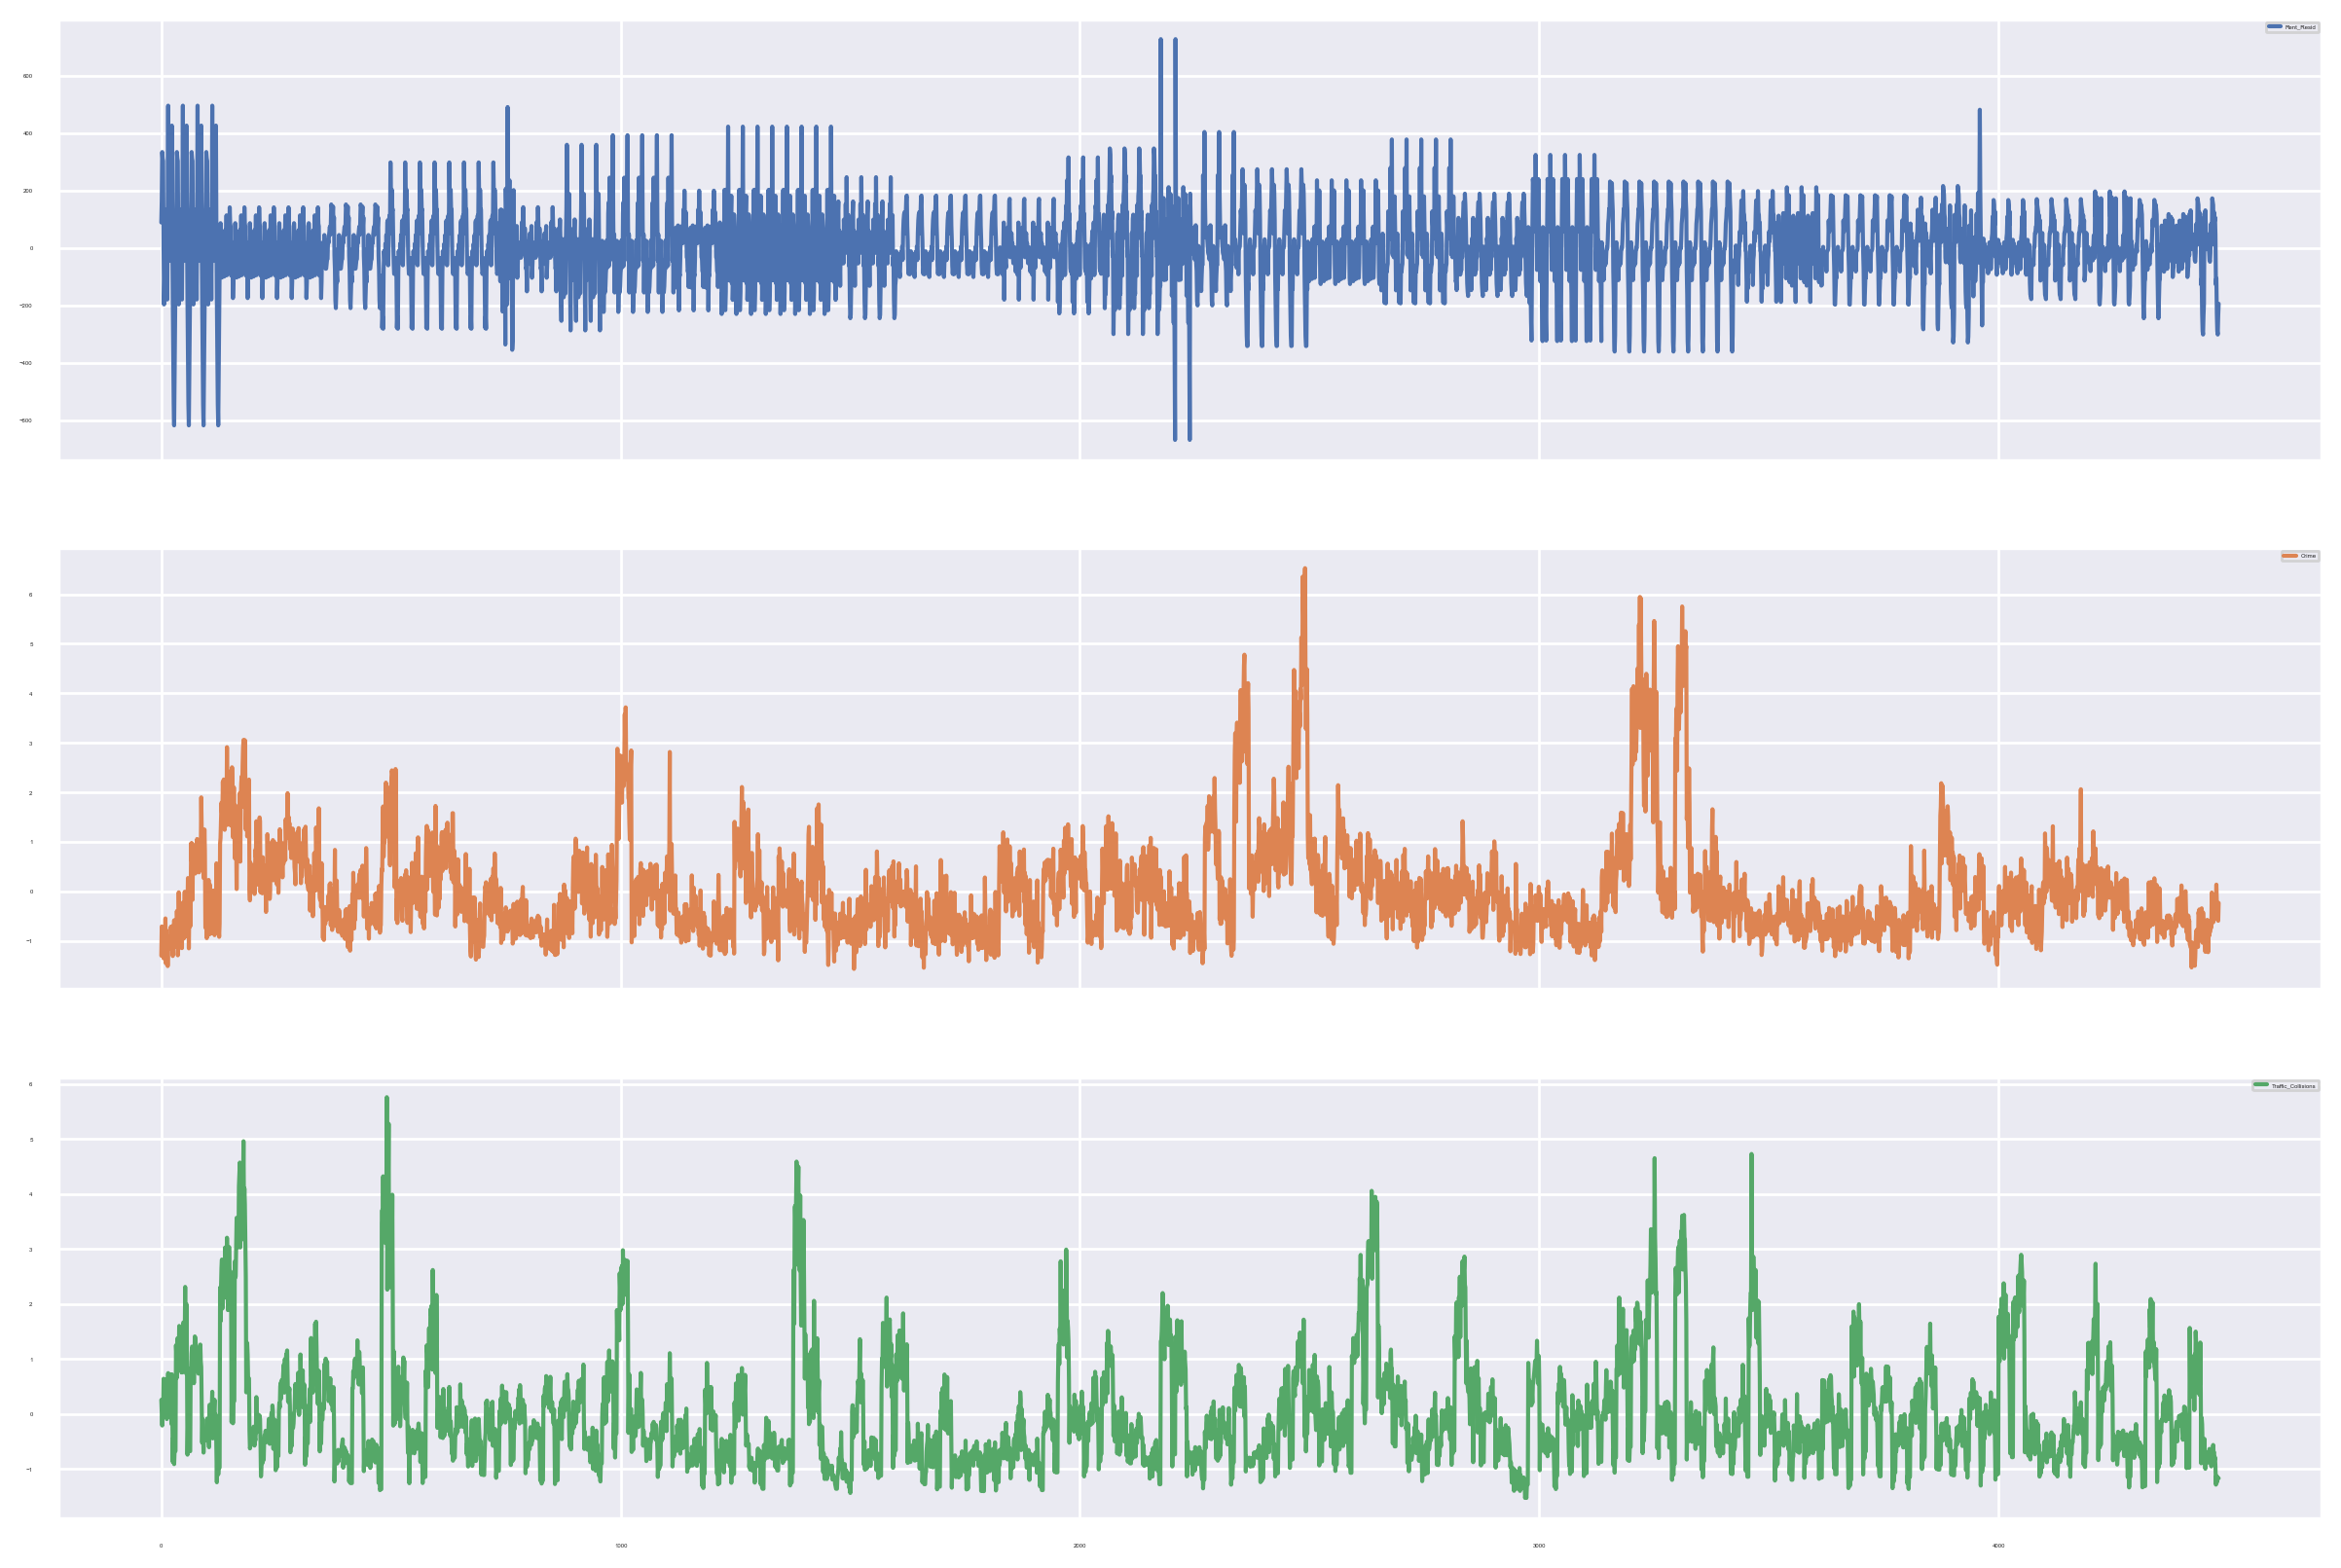

In [398]:
tseries_df.plot(subplots = True, use_index = False)

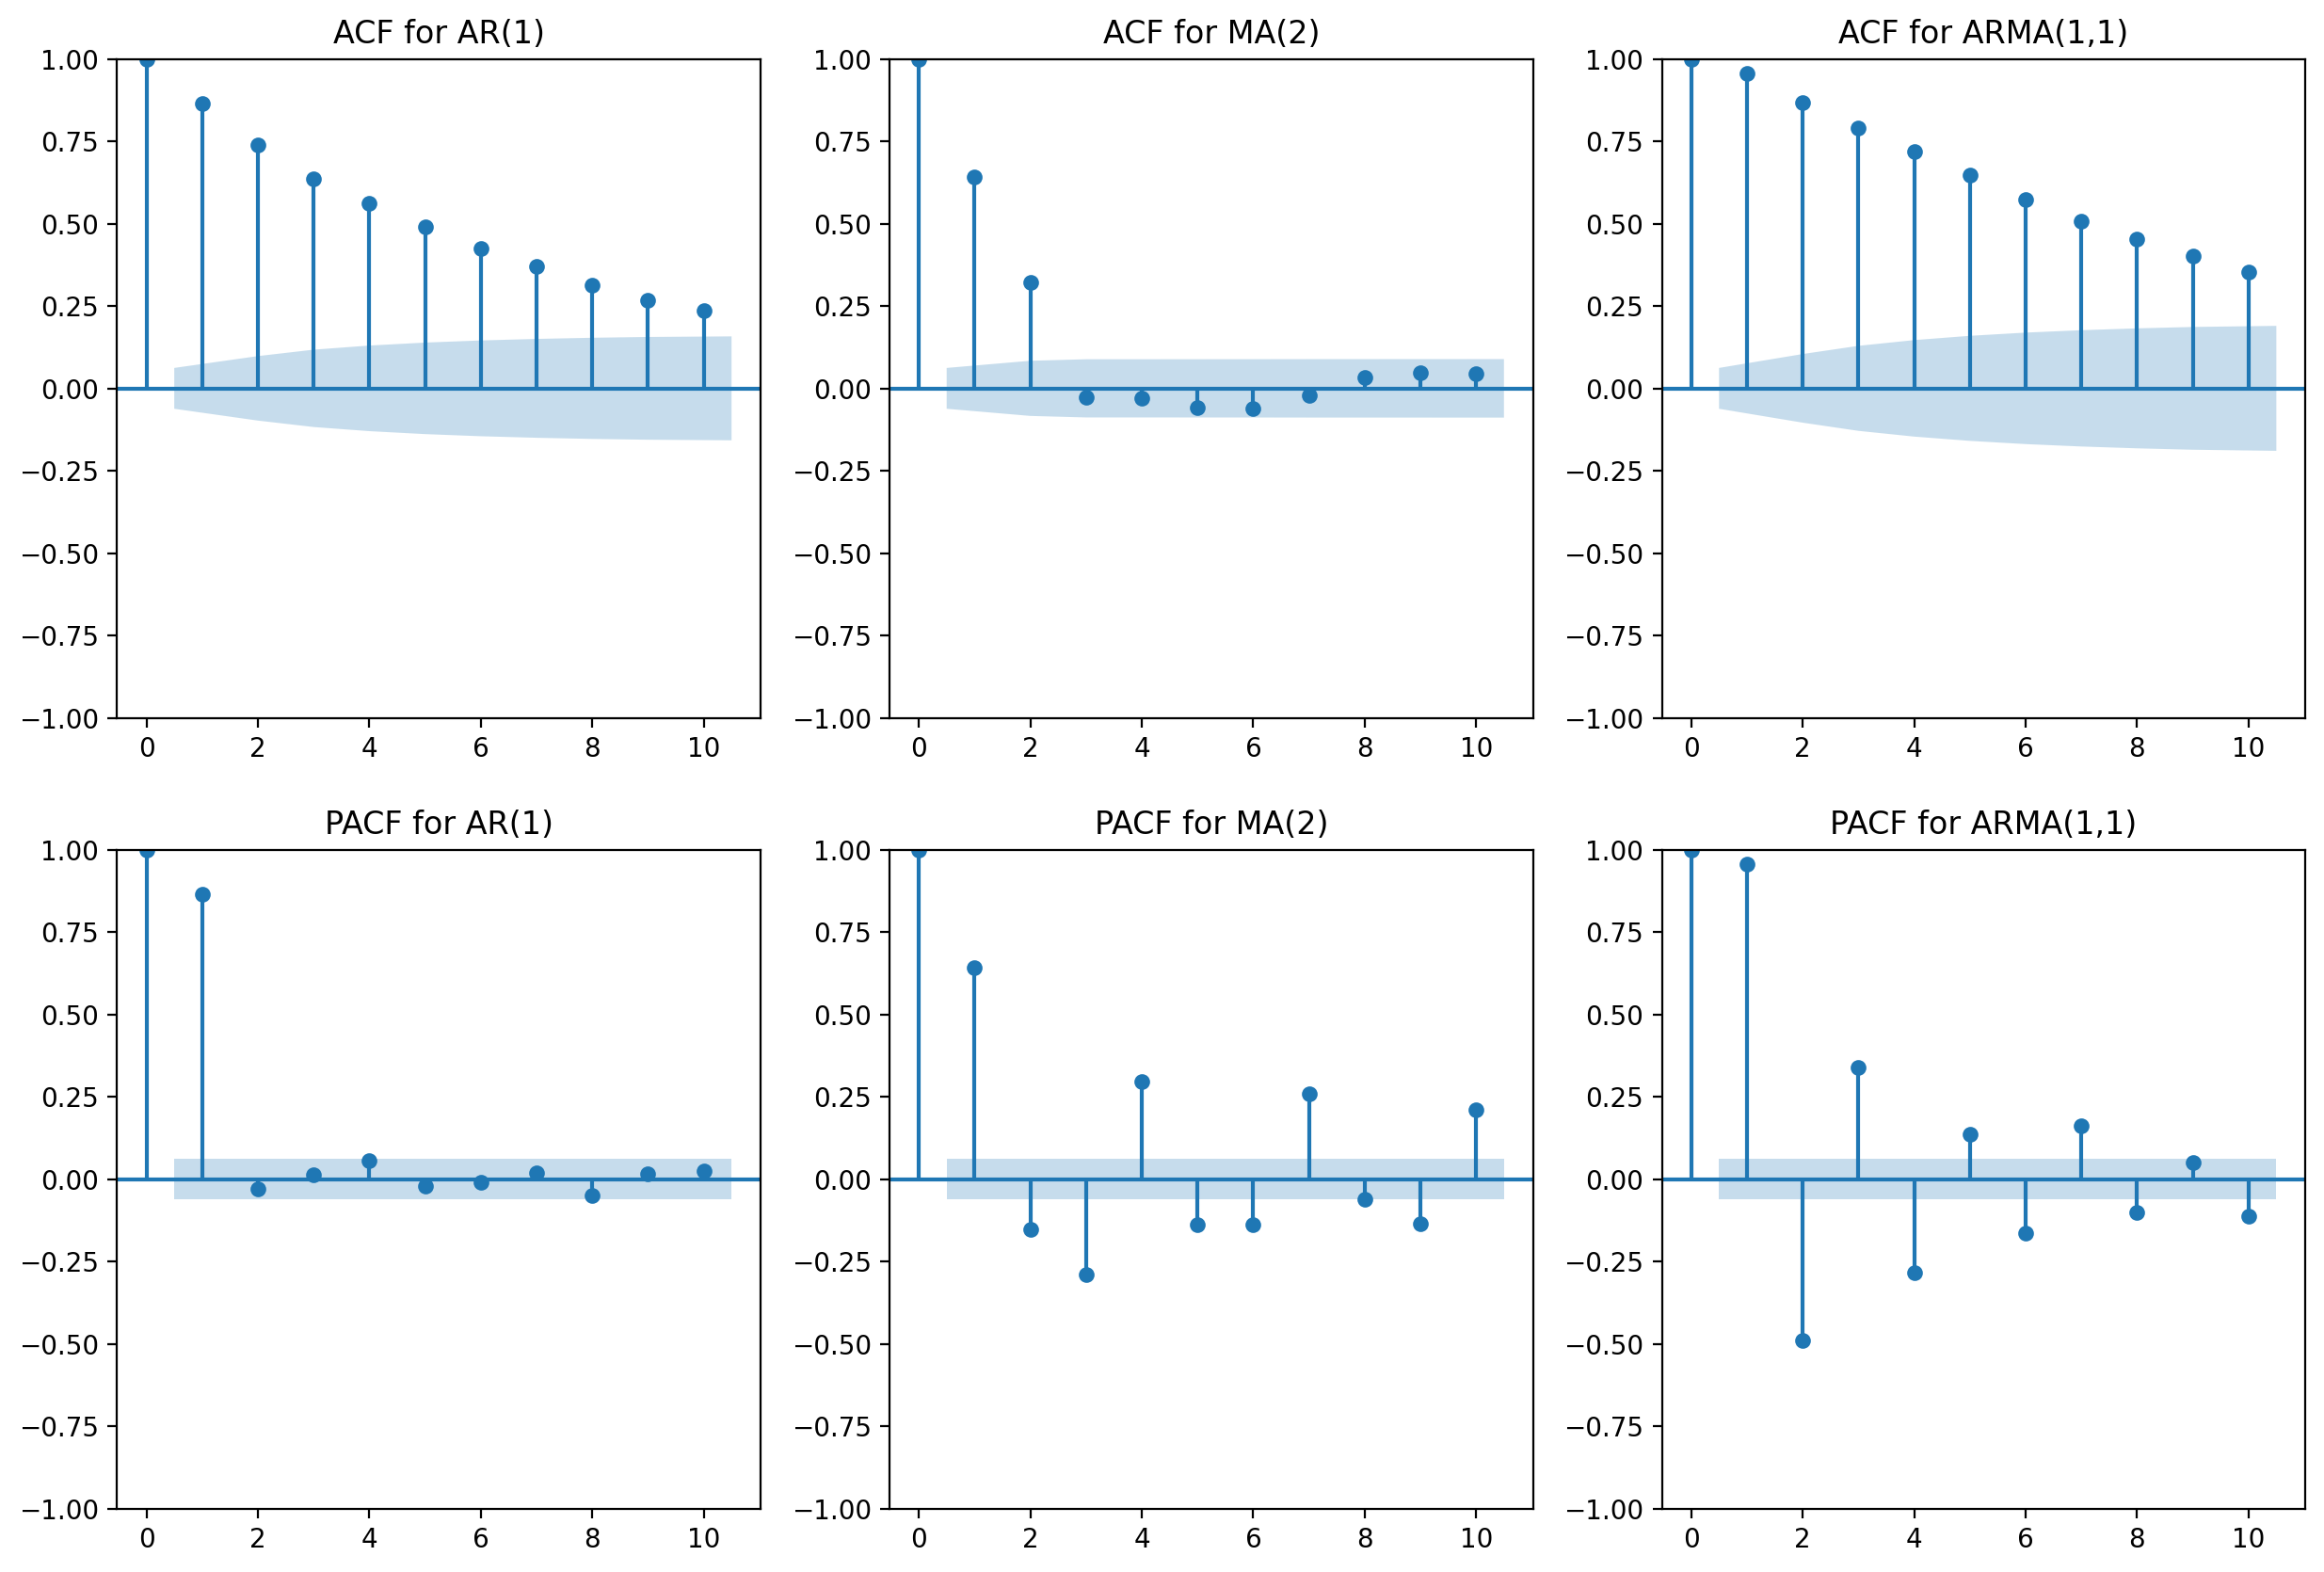

In [421]:
# sample ACF and PACF plot for AR and MA models
ar = np.array([1, -0.9])
ma = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_AR = AR_object.generate_sample(nsample = 1000)
ar = np.array([1])
ma = np.array([1, 0.9, 0.9])
MA_object = ArmaProcess(ar, ma)
simulated_MA = MA_object.generate_sample(nsample = 1000)
ar = np.array([1, -0.9])
ma = np.array([1, 0.9])
ARMA_object = ArmaProcess(ar, ma)
simulated_ARMA = ARMA_object.generate_sample(nsample = 1000)
fig, axes = plt.subplots(2, 3)
lag = 10
_ = tsaplots.plot_acf(simulated_AR, lags = lag, ax = axes[0,0], title='ACF for AR(1)')
_ = tsaplots.plot_pacf(simulated_AR, lags = lag, ax = axes[1,0], method = 'ywm', title='PACF for AR(1)')
_ = tsaplots.plot_acf(simulated_MA, lags = lag, ax = axes[0,1], title='ACF for MA(2)')
_ = tsaplots.plot_pacf(simulated_MA, lags = lag, ax = axes[1,1], method = 'ywm', title='PACF for MA(2)')
_ = tsaplots.plot_acf(simulated_ARMA, lags = lag, ax = axes[0,2], title='ACF for ARMA(1,1)')
_ = tsaplots.plot_pacf(simulated_ARMA, lags = lag, ax = axes[1,2], method = 'ywm', title='PACF for ARMA(1,1)')

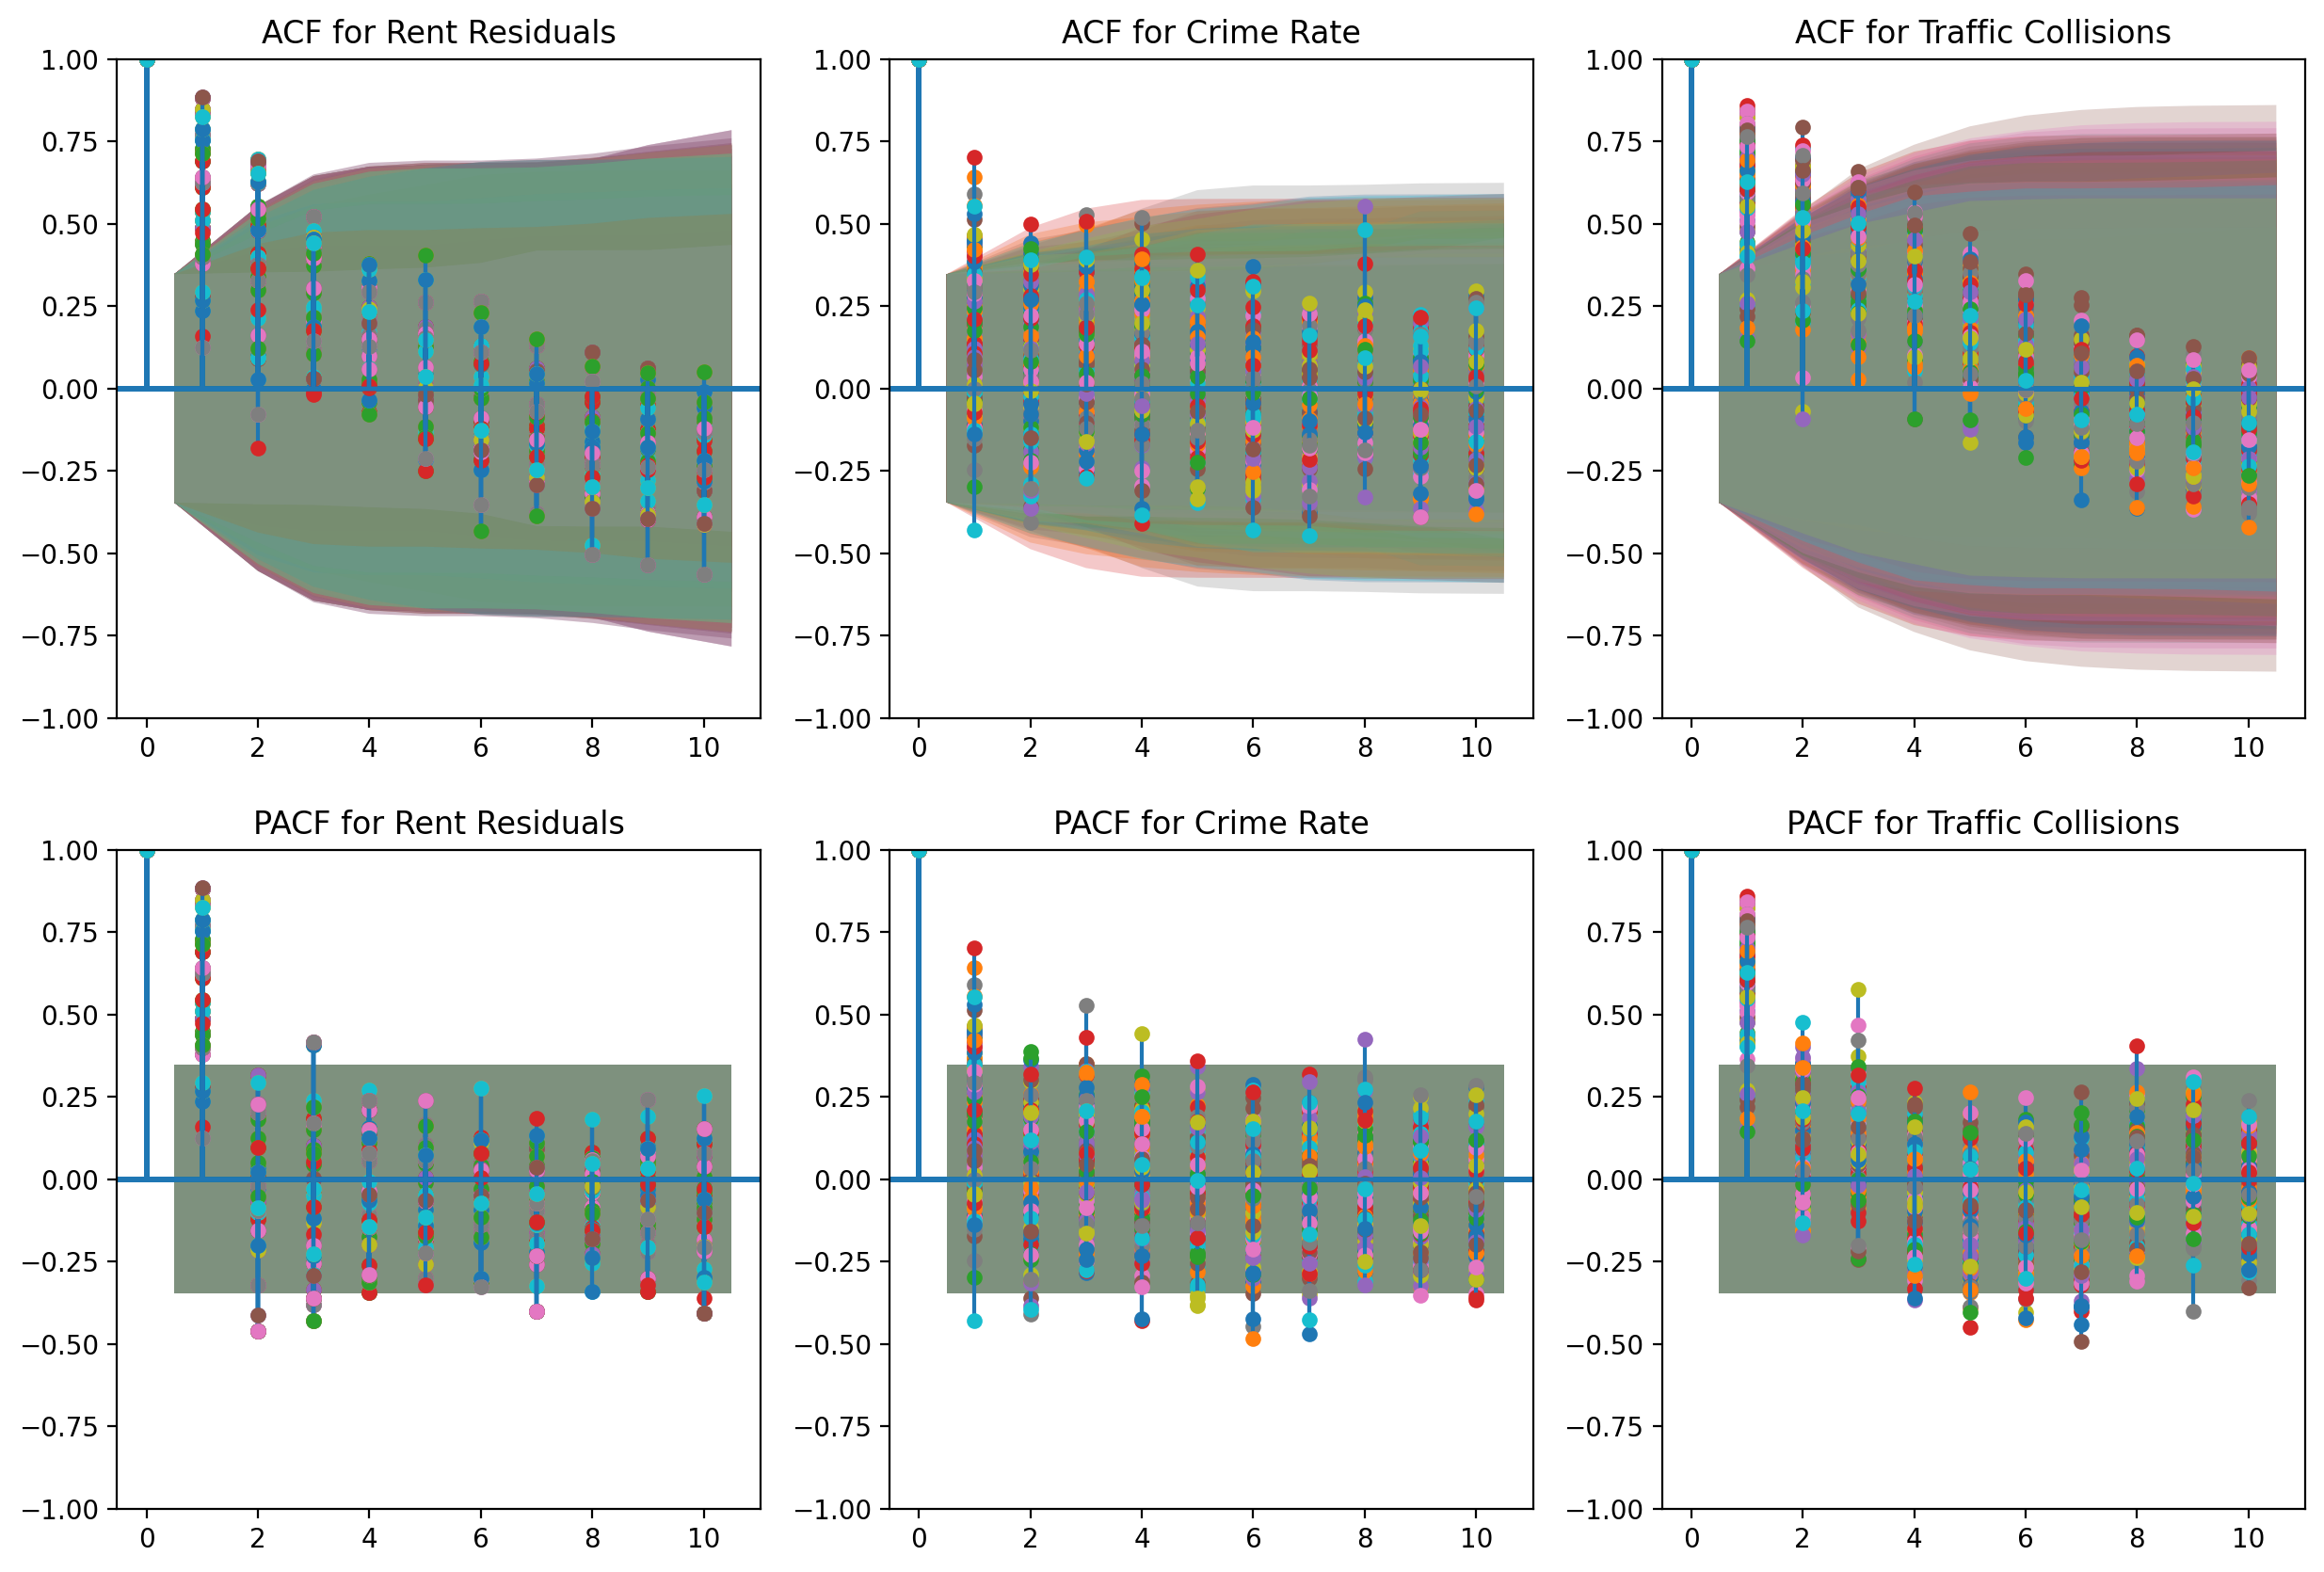

In [422]:
fig, axes = plt.subplots(2, 3)
lag = 10
for hood in tseries_df.hood_id.unique():    
    _ = tsaplots.plot_acf(tseries_df.Rent_Resid[tseries_df.hood_id == hood], lags = lag, ax = axes[0,0], title = 'ACF for Rent Residuals')
    _ = tsaplots.plot_pacf(tseries_df.Rent_Resid[tseries_df.hood_id == hood], lags = lag, ax = axes[1,0], method = 'ywm', title = 'PACF for Rent Residuals')
    _ = tsaplots.plot_acf(tseries_df.Crime[tseries_df.hood_id == hood], lags = lag, ax = axes[0,1], title = 'ACF for Crime Rate')
    _ = tsaplots.plot_pacf(tseries_df.Crime[tseries_df.hood_id == hood], lags = lag, ax = axes[1,1], method = 'ywm', title = 'PACF for Crime Rate')
    _ = tsaplots.plot_acf(tseries_df.Traffic_Collisions[tseries_df.hood_id == hood], lags = lag, ax = axes[0,2], title = 'ACF for Traffic Collisions')
    _ = tsaplots.plot_pacf(tseries_df.Traffic_Collisions[tseries_df.hood_id == hood], lags = lag, ax = axes[1,2], method = 'ywm', title = 'PACF for Traffic Collisions')

## Panel auto ARMA 

In [224]:
def panel_autoARMA(column, max_p = 3, max_q = 3):
    ar_choice = []
    ma_choice = []
    bic_choice = []
    warnings.simplefilter('ignore')
    
    for ar in range(max_p + 1):
        for ma in range(max_q + 1):
            ar_choice.append(ar)
            ma_choice.append(ma)
            bic_list = []
            for hood in tseries_df.hood_id.unique():    
                try:
                    model = ARIMA(tseries_df[column][tseries_df.hood_id == hood], order = (ar, 0, ma)).fit()
                    bic_list.append(model.bic)
                except:
                    bic_list.append(np.nan)
            bic_choice.append(bic_list)
    return pd.DataFrame({'AR': ar_choice, 
                         'MA': ma_choice, 
                         'BIC_5th': [np.nanquantile(x,0.05) for x in bic_choice],
                         'BIC_25th': [np.nanquantile(x,0.25) for x in bic_choice],
                         'BIC_avg': [np.nanmean(x) for x in bic_choice],
                         'BIC_75th': [np.nanquantile(x,0.75) for x in bic_choice],
                         'BIC_95th': [np.nanquantile(x,0.95) for x in bic_choice]})

In [225]:
resid_arma = panel_autoARMA('Rent_Resid')
crime_arma = panel_autoARMA('Crime')
traffic_arma = panel_autoARMA('Traffic_Collisions')

In [226]:
def plot_BIC(BIC_df, ax = None, title = ""):
    columns = ['BIC_5th', 'BIC_25th', 'BIC_avg', 'BIC_75th', 'BIC_95th']
    if ax is None:
        ax = BIC_df[columns].plot()
    else:
        BIC_df[columns].plot(ax = ax)
    suggestion_90pct = BIC_df[['BIC_5th', 'BIC_95th']].sum(axis=1).idxmin()
    ax.set_title(title + f" / Suggested ARMA: ({BIC_df['AR'][suggestion_90pct]}, {BIC_df['MA'][suggestion_90pct]})")
    ax.set_ylabel('BIC')
    ax.set_xlabel('ARMA (p,q)')
    ax.set_xticks(BIC_df.index)
    ax.set_xticklabels([','.join([str(x),str(y)]) for x, y in zip(BIC_df.AR, BIC_df.MA)])
    return ax

<AxesSubplot:title={'center':'Traffic Collisions / Suggested ARMA: (1, 0)'}, xlabel='ARMA (p,q)', ylabel='BIC'>

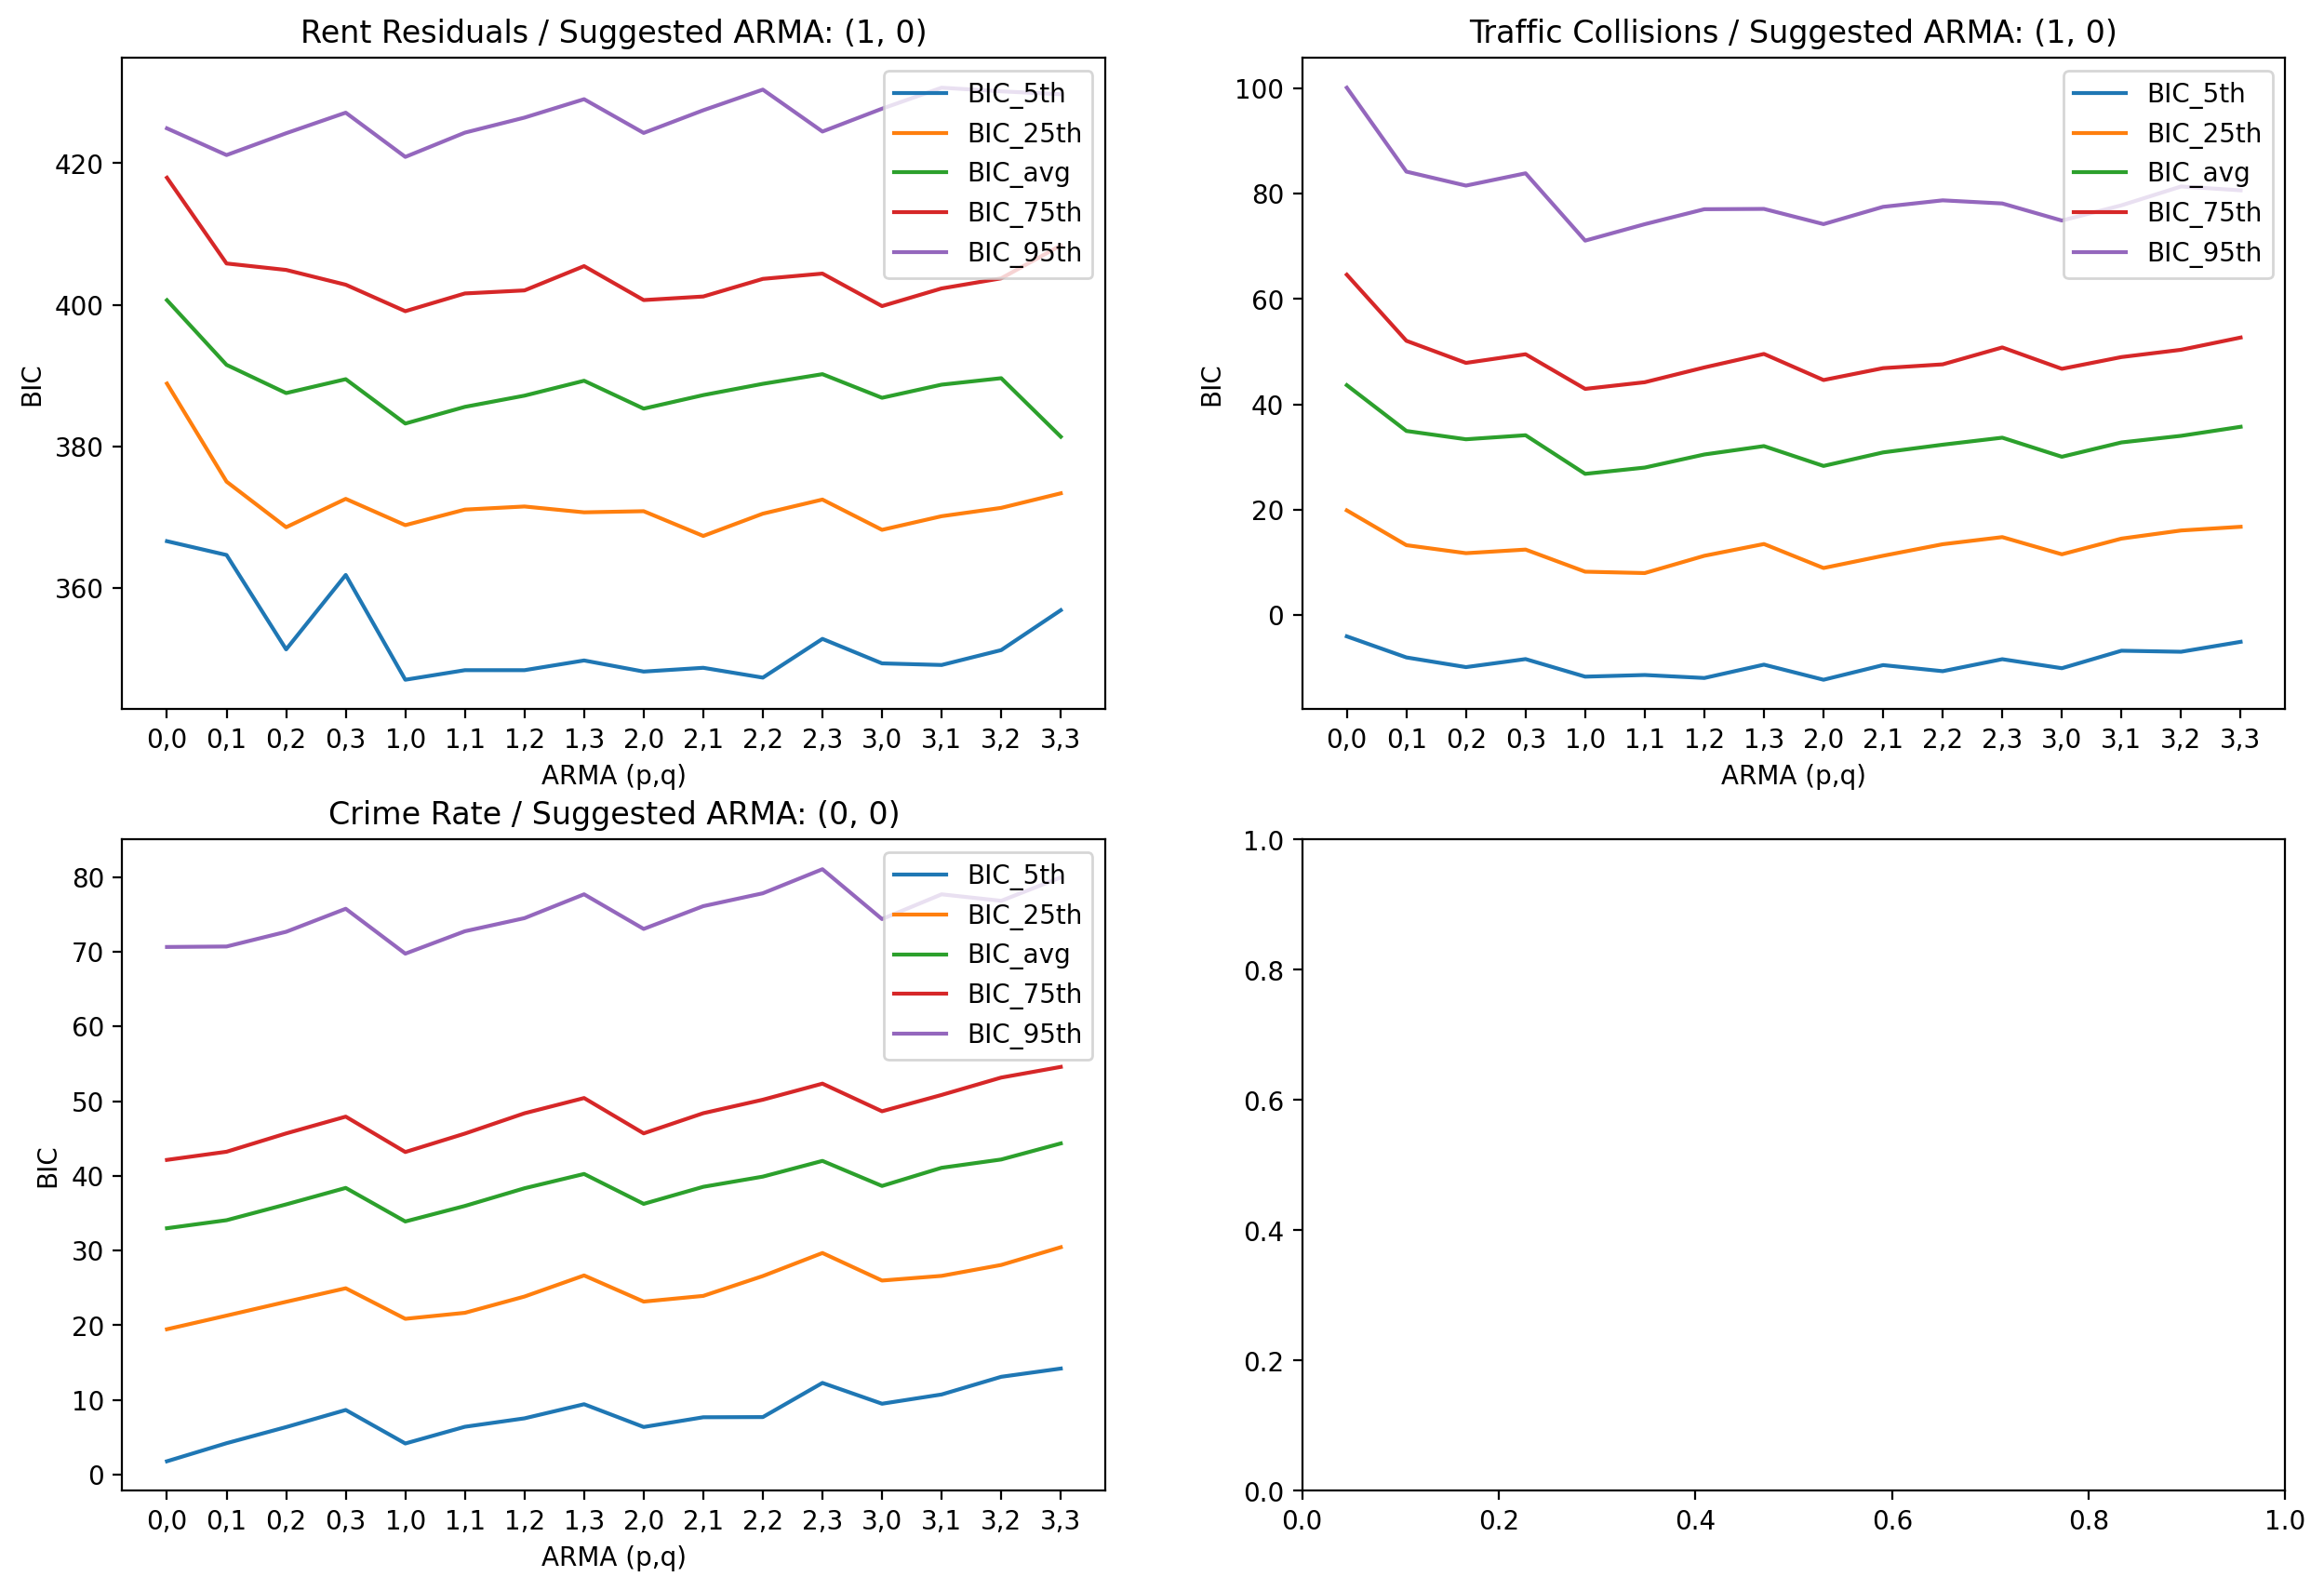

In [227]:
fig, axes = plt.subplots(2, 2)
plot_BIC(resid_arma, axes[0,0], 'Rent Residuals')
plot_BIC(crime_arma, axes[1,0], 'Crime Rate')
plot_BIC(traffic_arma, axes[0,1], 'Traffic Collisions')

## Out-sample forecast

In [342]:
def arma_predict(hood, ar, ma, column):
    return ARIMA(tseries_df[column][tseries_df.hood_id == hood], order = (ar, 0, ma)).fit().forecast()[0]

In [345]:
# 1-step forecast
pred_df = pd.DataFrame({'hood_id': tseries_df.hood_id.unique(),
                        'Time': (tseries_df.index.max() + 1).year + (tseries_df.index.max() + 1).quarter / 4, 
                        'Rent_Resid': [arma_predict(x, 1, 0, 'Rent_Resid') for x in tseries_df.hood_id.unique()],
                        'Crime': [arma_predict(x, 0, 0, 'Crime') for x in tseries_df.hood_id.unique()],
                        'Traffic_Collisions': [arma_predict(x, 1, 0, 'Traffic_Collisions') for x in tseries_df.hood_id.unique()]})

In [346]:
pred_df

hood_id     Time  Rent_Resid     Crime  Traffic_Collisions
0        97  2022.25  -50.245986 -1.008334           -0.339028
1        96  2022.25  -50.245986 -0.587025           -0.170369
2        95  2022.25  -50.245986  0.722442           -0.291759
3        94  2022.25  -50.245986 -0.427737           -0.758610
4        27  2022.25  -13.772773  1.808505            0.569870
..      ...      ...         ...       ...                 ...
135      50  2022.25  -99.215251 -0.346878           -0.665043
136     131  2022.25   -3.180638 -0.711692           -0.670867
137     132  2022.25   -3.180638 -0.416535           -0.875098
138      99  2022.25 -172.636526 -0.952801           -0.309779
139     104  2022.25 -172.636526 -0.561622           -1.082338

[140 rows x 5 columns]

In [423]:
output = pd.DataFrame({
    'hood_id': pred_df.hood_id,
    'Time': pred_df.Time,
    'All_Apartments_Avg_Lease_Rate_Per_Room': best_subset.predict({'hood_id': pred_df.hood_id, 'Time': pred_df.Time}),
    'MCI_Rate': pred_df['Crime'] * regression_table['MCI_Rate'].std() + regression_table['MCI_Rate'].mean(),
    'Collision_Rate': pred_df['Traffic_Collisions'] * regression_table['Collision_Rate'].std() + regression_table['Collision_Rate'].mean()
})

output

hood_id     Time  All_Apartments_Avg_Lease_Rate_Per_Room    MCI_Rate  \
0        97  2022.25                             2418.682756  125.652372   
1        96  2022.25                             2418.682756  193.717132   
2        95  2022.25                             2418.682756  405.268419   
3        94  2022.25                             2418.682756  219.450901   
4        27  2022.25                             1558.023298  580.727706   
..      ...      ...                                     ...         ...   
135      50  2022.25                             1670.090409  232.514014   
136     131  2022.25                             1232.904940  173.576374   
137     132  2022.25                             1232.904940  221.260586   
138      99  2022.25                             1894.922561  134.624022   
139     104  2022.25                             1894.922561  197.821060   

     Collision_Rate  
0        366.683260  
1        415.573058  
2        380.385328  
3        245.057681  
4        630.148663  
..              ...  
135      272.180471  
136      270.492264  
137      211.290970  
138      375.161963  
139      151.217790  

[140 rows x 5 columns]

In [354]:
output.to_csv('./clean_data/neighbourhoods_prediction.csv')

# Difference among neighbourhoods?
- if there is no difference, we can model the average lease rate as a single time series
- otherwise we need to model each neighbourhood separately

In [ ]:
# Instead of performing an ANOVA to see if we can assume all neighbourhoods share the same average lease rate,
# We can perform an F test for the regression of Rent against dummy variables representing each neighborhoods
# if at least one of the params is different from 0, we can reject the null hypothesis that all neighbourhoods share the same average rent
# the F statistic here is large enough for us to reject the null
sm.OLS(regression_df[Y], sm.add_constant(pd.get_dummies(regression_table['hood_id']))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rent   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     66.27
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        17:53:35   Log-Likelihood:                -29814.
No. Observations:                4480   AIC:                         5.991e+04
Df Residuals:                    4340   BIC:                         6.081e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1353.3555      2.832    477.828      0.000    1347.803    1358.908
1           -225.9532     33.631     -6.719      0.000    -291.887    -160.019
10            12.0098     33.631      0.357      0.721     -53.924      77.944
100          196.3178     33.631      5.837      0.000     130.384     262.252
101          196.3178     33.631      5.837      0.000     130.384     262.252
102          118.4788     33.631      3.523      0.000      52.545     184.413
103          118.4788     33.631      3.523      0.000      52.545     184.413
104          292.2128     33.631      8.689      0.000     226.279     358.147
105          118.4788     33.631      3.523      0.000      52.545     184.413
106          196.3178     33.631      5.837      0.000     130.384     262.252
107          196.3178     33.631      5.837      0.000     130.384     262.252
108         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
109         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
11            12.0098     33.631      0.357      0.721     -53.924      77.944
110         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
111         -267.0796     33.631     -7.941      0.000    -333.013    -201.146
112         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
113         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
114          196.4096     33.631      5.840      0.000     130.476     262.343
115         -127.6513     33.631     -3.796      0.000    -193.585     -61.718
116         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
117         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
118         -276.8182     33.631     -8.231      0.000    -342.752    -210.884
119         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
12            12.0098     33.631      0.357      0.721     -53.924      77.944
120         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
121          -78.1144     33.631     -2.323      0.020    -144.048     -12.181
122          -78.1144     33.631     -2.323      0.020    -144.048     -12.181
123         -378.3139     33.631    -11.249      0.000    -444.248    -312.380
124         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
125         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
126         -281.3806     33.631     -8.367      0.000    -347.314    -215.447
127          -91.3663     33.631     -2.717      0.007    -157.300     -25.432
128         -239.3390     33.631     -7.117      0.000    -305.273    -173.405
129         -239.3390     33.631     -7.117      0.000    -305.273    -173.405
13            12.0098     33.631      0.357      0.721     -53.924      77.944
13

# Improvement
- cross validation https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html#Specifying-the-number-of-forecasts 

# Notes

Assumptions to check
- Multicollinearity
  - Why is it a problem?
    1) Hard to interpret the parameters as the sign can become opposite
    2) Hard to make inferences about the parameters as standard errors can be wrong
    - Check for below signs:
      1) Significant correlations between independent variables
      2) Variance inflation factor (VIF) > 10
- There should be no outliers and influential observations
  - Outliers may represent erroneous data which should be corrected
  - Influential observations are observations far from its mean (i.e. observations with high leverage)
      - They can have a strong impact on the value of parameters estimated, rendering any t test or F test useless in measuing model's performance
  - Cook's distance measures both leverage and residual of each observation
      -  Cook's distance > 1 indicates an influential observation that can severly impact the regression results

Residual diagnostics
- To conduct hypothesis testing of regression coefficients and form prediction intervals of future values of y, we must satisfy the following assumptions:
- (1) ε is normally distributed,
- (2) with a mean of 0, 
- (3) the variance σ^2 is constant, and 
- (4) all pairs of error terms are uncorrelated

<img src='../data/image/2022-05-08-00-44-27.png'>
<img src='../data/image/2022-05-08-00-45-04.png'>

In [ ]:
# np.random.seed(123)
# calculating many bootstrap replicates
# def draw_bs_reps(df, size=10**4):
#     """Draw bootstrap replicates of linear regression."""

#     # Initialize array of replicates: bs_replicates
#     # bs_replicates = None
#     bs_replicates_intercept = np.empty(size)
#     bs_replicates_slope1 = np.empty(size)
#     bs_replicates_slope2 = np.empty(size)
#     # Generate replicates
#     for i in range(size):
#         inds = np.arange(df.shape[0])
#         # generate a list of indices with replcaement with the same size as our original dataframe
#         # to ensure the distribution of bootstrap replicates is the same as that of our estimated coefficients
#         bs_inds = np.random.choice(inds, size = len(inds), replace = True)
#         # pairwise bootstrapping on Y and Xs
#         bootstrap_df = df.iloc[bs_inds]
#         X_df = bootstrap_df[[*best_subsets]]
#         X_df.insert(0, 'Intercept', 1)
#         # use (Moore-Penrose) pseudo-inverse to speed up regression since we only need the estimated coefficients
#         bs_replicates_intercept[i], bs_replicates_slope1[i], bs_replicates_slope2[i] = np.linalg.pinv(X_df) @ bootstrap_df[Y]

#     return bs_replicates_intercept, bs_replicates_slope1, bs_replicates_slope2

#### Confidence Intervals
Let's compare the confidence interval of regression coefficients with the following obtained from bootstrapped samples:
  - Normal interval
  - Percentile interval
  - Bias corrected interval

While t tests from regression are significant for all estimated coefficients,
  - Bootstrapping helps verify that 
    - We can be 95% confident that our confidence intervals would contain the true coefficients after adjusting familywise error rate (FWER) with Bonferroni correction to address statistical multiplicity
    - Violation of residual assumptions are not extreme enough to significantly impact our confidence intervals and statistical tests of estimated parameters
  - Since 0 is not within our confidence intervals, all of our estimated coefficients are significant

In [ ]:
# normal, percentile, BC + Lower Bound / Upper Bound
# bonferroni_correction = 2 # number of t tests to be conducted simultaneously
# alpha = 0.05 / bonferroni_correction # 95% confidence interval corrected by Bonferroni correction to address statistical multiplicity
# tails = 2 # two-tailed test
# intervals = None

# for i, (sample_statistic, bs_statistic) in enumerate(zip([slope1, slope2], 
#                                                          [bs_slope1, bs_slope2])):
    
#     # OLS intervals
#     # ols_interval = best_subsets_results.conf_int().iloc[i+1].tolist()
    
#     # normal intervals
#     normal = stats.norm.ppf(alpha/tails)
#     normal_interval = [sample_statistic + normal * np.std(bs_statistic), sample_statistic - normal * np.std(bs_statistic)]
    
#     # percentile intervals
#     percentile = [alpha/tails*100, (1-alpha/tails)*100]
#     percentile_interval = np.percentile(bs_statistic, percentile)
    
#     # Bias corrected intervals (BC)
#     bias_correction = stats.norm.ppf(sum(bs_statistic <= sample_statistic) / len(bs_statistic)) # remove statistical bias due to randomness
#     bc_percentile = [stats.norm.cdf(bias_correction + normal)*100, stats.norm.cdf(bias_correction - normal)*100]
#     bc_interval = np.percentile(bs_statistic, bc_percentile)
    
#     intervals = pd.concat([intervals, pd.DataFrame([normal_interval, percentile_interval, bc_interval])])

# intervals

# intervals_index = pd.MultiIndex.from_arrays([np.repeat([*best_subsets_results.params.index.values[1:]],3).tolist(),
#                                              ['Normal', 'Percentile', 'Bias Corrected']*int(intervals.shape[0]/3)],
#                                             names = ['Coefficients', 'Confidence Intervals'])
# intervals_columns = [f'{(1-alpha*bonferroni_correction)*100:0.0f}% CI Lower Bound', f'{(1-alpha*bonferroni_correction)*100:0.0f}% CI Upper Bound']
# intervals.index = intervals_index
# intervals.columns = intervals_columns
# intervals

95% CI Lower Bound  95% CI Upper Bound
Coefficients Confidence Intervals                                        
Lease_Demand Normal                         12.058286           31.900529
             Percentile                     12.155857           31.979526
             Bias Corrected                 12.158712           31.983661
Distance     Normal                       -196.645175         -178.456662
             Percentile                   -196.612066         -178.503892
             Bias Corrected               -196.606744         -178.501091